In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import linregress
import matplotlib as mpl
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

pd.options.mode.chained_assignment = None
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12

# Now you can import hrdtimer
from hrdtimer import MolecularTimeToAge

## Old data

In [ ]:
NormalTissue = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/data/NormalTissue_SBS1_Age_plot.csv", index_col=0)
BulkTumor =  pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/PCAWG_SCANB_INFORM_SBS1_Age_plot.csv", index_col=0)
PCAWG_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001.csv")
SCANB_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/SCANB_unfiltered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv")
INFORM_HRDTimer = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/INFORM_germline_filtered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv")

# New data + merge with receptor status for informed timing. 

In [2]:
# Updated with final run 
NormalTissue = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/NormalTissue_SBS1_Age_plot.csv", index_col=0)
BulkTumor =  pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/PCAWG_SCANB_INFORM_SBS1_Age_plot.csv", index_col=0)
PCAWG_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv")
SCANB_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/SCANB_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot.csv")
INFORM_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/INFORM_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv")

metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v5.csv")

# Merge 'sample.display' into BulkTumor using sample -> aliquot_id
BulkTumor = BulkTumor.merge(
    metadata[['sample', 'sample.display']],
    how='left',
    left_on='aliquot_id',
    right_on='sample'
)

In [2]:
# === Load HRDTimer data ===
BulkTumor =  pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/PCAWG_SCANB_INFORM_SBS1_Age_plot.csv", index_col=0)
PCAWG_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv")
SCANB_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/SCANB_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot.csv")
INFORM_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/INFORM_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv")

# === Load filtered timing data ===
timing_filtered_data = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")
pass_sample_IDs = timing_filtered_data[timing_filtered_data['removed'] != True]['ID'].tolist()


# === Load metadata ===
meta = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v5.csv")

allowed_type = ['TN', 'ER-', 'ER+']
meta['timing_class'] = meta.apply(
    lambda row: row['type'] if row['type'] in allowed_type else row['grade'],
    axis=1
)

# === Merge helper: merge HRDTimer + meta + BulkTumor ===
def merge_with_meta_and_bulk(hrd_df, meta_df, bulk_df, dataset_name):
    hrd_df = hrd_df[hrd_df['ID'].isin(pass_sample_IDs)]

    dataset_meta = meta_df[meta_df['dataset'] == dataset_name]

    # Merge HRDTimer + meta (inner = only common)
    merged = pd.merge(
        hrd_df,
        dataset_meta,
        left_on='ID',
        right_on='sample',
        how='inner'
    ).drop(columns=['sample'])

    # Merge with BulkTumor using aliquot_id
    merged = pd.merge(
        merged,
        bulk_df[['aliquot_id', 'scaled_SBS1']],
        how='left',
        left_on='ID',
        right_on='aliquot_id'
    ).drop(columns=['aliquot_id'])

    return merged

# === Merge all datasets ===
PCAWG_merged = merge_with_meta_and_bulk(PCAWG_HRDTimer, meta, BulkTumor, 'PCAWG')
SCANB_merged = merge_with_meta_and_bulk(SCANB_HRDTimer, meta, BulkTumor, 'SCANB')
INFORM_merged = merge_with_meta_and_bulk(INFORM_HRDTimer, meta, BulkTumor, 'INFORM')


# NEW RUN

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_line(x, slope, intercept):
    return slope * x + intercept

def plot_filled_lines(ax, y, WGD, HRD, W_err_hi, W_err_lo, H_err_hi, H_err_lo):
    y_val = y.values[0]
    ax.fill_betweenx(
        y=[(WGD - W_err_lo) * y_val, (WGD + W_err_hi) * y_val],
        x1=ax.get_xlim()[0], x2=85, color='#e68f32', alpha=0.5
    )
    ax.axhline(y=WGD * y_val, color='#e68f32', linestyle='--')

    ax.fill_betweenx(
        y=[(HRD - H_err_lo) * y_val, (HRD + H_err_hi) * y_val],
        x1=ax.get_xlim()[0], x2=85, color='#21255e', alpha=0.5
    )
    ax.axhline(y=HRD * y_val, color='#21255e', linestyle='--')

def analyze_cohort_timing(cohort_name, bulk_tumor_df, hrd_timer_df, output_csv, output_fig=None, late_SBS1_burden=0):
    samples = bulk_tumor_df[bulk_tumor_df['Cohort'] == cohort_name]
    merged = pd.merge(samples, hrd_timer_df, left_on='aliquot_id', right_on='ID').drop(columns='ID')

    x_values = np.linspace(0, 90, 1000)
    ref_slope = 0.0002569
    slope_max = 30 * ref_slope

    results = []
    IDs = merged['aliquot_id'].unique()
    nrows, ncols = -(-len(IDs) // 5), 5
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
    axs = axs.flatten()

    def intersect_lines(m1, b1, m2, b2):
        return (b2 - b1) / (m1 - m2) if abs(m1 - m2) >= 1e-14 else np.nan

    def min_positive(*args):
        pos = [x for x in args if x is not None and not np.isnan(x) and x > 0]
        return min(pos) if pos else np.nan

    for idx, sid in enumerate(IDs):
        d = merged[merged['aliquot_id'] == sid]
        if d['scaled_SBS1_y'].empty or d['age_y'].empty:
            continue
        x_breast, y_breast = d['age_y'].values[0], d['scaled_SBS1_y'].values[0]
        if pd.isna(x_breast) or x_breast == 0:
            continue

        display_id = d['sample.display'].values[0]
        timing_class = d['timing_class'].values[0] if 'timing_class' in d.columns else 'Unknown'

        WGD, HRD = d[['WGDTime', 'HRDTime']].values[0]
        W_err_hi, W_err_lo, H_err_hi, H_err_lo = d[['WGDTime_ci_hi', 'WGDTime_ci_lo', 'HRDTime_ci_hi', 'HRDTime_ci_lo']].values[0]

        y_breast_corrected = y_breast + late_SBS1_burden
        ax = axs[idx]

        plot_filled_lines(ax, pd.Series(y_breast), WGD, HRD, W_err_hi, W_err_lo, H_err_hi, H_err_lo)

        ax.plot(x_values, ref_slope * x_values, color='grey', linestyle='-')
        intercept_max = y_breast_corrected - slope_max * x_breast
        ax.plot(x_values, slope_max * x_values + intercept_max, '--', color='k')

        duration = 10.5 if timing_class == 'TN' else 16.3 if timing_class == 'ER+' else 0
        x_div = max(x_breast - duration, 1e-3)
        y_div = ref_slope * x_div

        slope_intermediate = (y_breast_corrected - y_div) / (x_breast - x_div)
        intercept_intermediate = y_breast_corrected - slope_intermediate * x_breast
        ax.plot(x_values, slope_intermediate * x_values + intercept_intermediate, '--', color='lightblue')

        straight_slope = y_breast_corrected / x_breast
        ax.plot(x_values, straight_slope * x_values, '--', color='grey')

        ax.scatter(x_breast, y_breast_corrected, color='orange', s=50, zorder=20)
        ax.scatter(x_breast, y_breast, color='red', s=20, zorder=20)
        ax.scatter(x_div, y_div, color='lightblue', s=40, zorder=20)

        # Compute y burdens
        y_vals = {
            'HRD': HRD * y_breast,
            'HRD_low': (HRD - H_err_lo) * y_breast,
            'HRD_high': (HRD + H_err_hi) * y_breast,
            'WGD': WGD * y_breast,
            'WGD_low': (WGD - W_err_lo) * y_breast,
            'WGD_high': (WGD + W_err_hi) * y_breast
        }

        def compute_all(y_val):
            return {
                'linear': y_val / straight_slope if straight_slope != 0 else np.nan,
                'norm_int': min_positive(
                    intersect_lines(ref_slope, 0, 0, y_val),
                    intersect_lines(slope_intermediate, intercept_intermediate, 0, y_val)
                ),
                'norm_max': min_positive(
                    intersect_lines(ref_slope, 0, 0, y_val),
                    intersect_lines(slope_max, intercept_max, 0, y_val)
                )
            }

        HRD_results = {k: compute_all(v) for k, v in y_vals.items() if 'HRD' in k}
        WGD_results = {k: compute_all(v) for k, v in y_vals.items() if 'WGD' in k}

        #ax.scatter([HRD_results['HRD']['norm_int']], [y_vals['HRD']], color='blue', s=40)
        #ax.scatter([WGD_results['WGD']['norm_int']], [y_vals['WGD']], color='green', s=40)
        #ax.scatter([HRD_results['HRD']['norm_max']], [y_vals['HRD']], color='cyan', s=40, marker='x')
        #ax.scatter([WGD_results['WGD']['norm_max']], [y_vals['WGD']], color='lime', s=40, marker='x')
        #ax.scatter([HRD_results['HRD']['linear']], [y_vals['HRD']], color='k', s=30)
        #ax.scatter([WGD_results['WGD']['linear']], [y_vals['WGD']], color='k', s=30)

        ax.set(
            title=f"{display_id} ({timing_class}) \n MRCA-diagnosis ({duration} [yr])",
            xlim=(0, 85),
            ylim=(0, 0.13),
            xlabel='Age',
            ylabel='SBS1 / G x 3000 Mb'
        )
        #ax.legend()

        def zero_floor(val):
            return max(0, val) if pd.notna(val) else val

        results.append({
            'ID': sid,
            'Age': x_breast,
            'HRD_linear': zero_floor(HRD_results['HRD']['linear']),
            'HRD_linear_low': zero_floor(HRD_results['HRD_low']['linear']),
            'HRD_linear_high': zero_floor(HRD_results['HRD_high']['linear']),
            'WGD_linear': zero_floor(WGD_results['WGD']['linear']),
            'WGD_linear_low': zero_floor(WGD_results['WGD_low']['linear']),
            'WGD_linear_high': zero_floor(WGD_results['WGD_high']['linear']),
            'HRD_norm_int': zero_floor(HRD_results['HRD']['norm_int']),
            'HRD_norm_int_low': zero_floor(HRD_results['HRD_low']['norm_int']),
            'HRD_norm_int_high': zero_floor(HRD_results['HRD_high']['norm_int']),
            'WGD_norm_int': zero_floor(WGD_results['WGD']['norm_int']),
            'WGD_norm_int_low': zero_floor(WGD_results['WGD_low']['norm_int']),
            'WGD_norm_int_high': zero_floor(WGD_results['WGD_high']['norm_int']),
            'HRD_norm_max': zero_floor(HRD_results['HRD']['norm_max']),
            'HRD_norm_max_low': zero_floor(HRD_results['HRD_low']['norm_max']),
            'HRD_norm_max_high': zero_floor(HRD_results['HRD_high']['norm_max']),
            'WGD_norm_max': zero_floor(WGD_results['WGD']['norm_max']),
            'WGD_norm_max_low': zero_floor(WGD_results['WGD_low']['norm_max']),
            'WGD_norm_max_high': zero_floor(WGD_results['WGD_high']['norm_max']),
        })

    pd.DataFrame(results).to_csv(output_csv, index=False)

    plt.tight_layout()
    if output_fig:
        plt.savefig(output_fig, format='pdf', bbox_inches='tight', dpi=600)
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_cohort_timing(cohort_name, bulk_tumor_df, hrd_timer_df, output_csv, output_fig=None, late_SBS1_burden=0):
    samples = bulk_tumor_df[bulk_tumor_df['Cohort'] == cohort_name]
    merged = pd.merge(samples, hrd_timer_df, left_on='aliquot_id', right_on='ID').drop(columns='ID')

    x_values = np.linspace(0, 90, 1000)
    ref_slope = 0.0002569
    slope_max = 30 * ref_slope

    results = []
    IDs = merged['aliquot_id'].unique()
    nrows, ncols = -(-len(IDs) // 5), 5
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
    axs = axs.flatten()

    def intersect_lines(m1, b1, m2, b2):
        return (b2 - b1) / (m1 - m2) if abs(m1 - m2) >= 1e-14 else np.nan
    
    def min_positive(*args):
        pos = [x for x in args if x is not None and not np.isnan(x)]
        if pos:
            return max(0, min(pos))  # floor to 0 if min is negative
        else:
            return np.nan

    def zero_floor(val):
        return max(0, val) if pd.notna(val) else val

    for idx, sid in enumerate(IDs):
        d = merged[merged['aliquot_id'] == sid]
        if d['scaled_SBS1_y'].empty or d['age_y'].empty:
            continue
        x_breast, y_breast = d['age_y'].values[0], d['scaled_SBS1_y'].values[0]
        if pd.isna(x_breast) or x_breast == 0:
            continue

        display_id = d['sample.display'].values[0]
        timing_class = d['timing_class'].values[0] if 'timing_class' in d.columns else 'Unknown'

        WGD, HRD = d[['WGDTime', 'HRDTime']].values[0]
        W_err_hi, W_err_lo, H_err_hi, H_err_lo = d[['WGDTime_ci_hi', 'WGDTime_ci_lo', 'HRDTime_ci_hi', 'HRDTime_ci_lo']].values[0]

        y_breast_corrected = y_breast + late_SBS1_burden
        ax = axs[idx]

        plot_filled_lines(ax, pd.Series(y_breast), WGD, HRD, W_err_hi, W_err_lo, H_err_hi, H_err_lo)
        # Plot slope lines
        ax.plot(x_values, ref_slope * x_values, color='grey', linestyle='-')
        duration = 10.5 if timing_class == 'TN' else 16.3 if timing_class == 'ER+' else 0
        x_div = max(x_breast - duration, 1e-3)
        y_div = ref_slope * x_div

        slope_intermediate = (y_breast_corrected - y_div) / (x_breast - x_div)
        intercept_intermediate = y_breast_corrected - slope_intermediate * x_breast
        intercept_max = y_breast_corrected - slope_max * x_breast
        straight_slope = y_breast_corrected / x_breast

        ax.plot(x_values, slope_intermediate * x_values + intercept_intermediate, '--', color='#658E9C')
        ax.plot(x_values, slope_max * x_values + intercept_max, '--', color='k')
        ax.plot(x_values, straight_slope * x_values, '--', color='grey')

        ax.scatter(x_breast, y_breast_corrected, color='#C9A690', edgecolors='black',
           linewidths=0.5, s=70, zorder=20, label='SBS1 incl. late')
        ax.scatter(x_breast, y_breast, color='#D36582', edgecolors='black',
           linewidths=0.5, s=30, zorder=20, label='SBS1 at MRCA')
        ax.scatter(x_div, y_div, color='#658E9C', s=70, edgecolors='black',
           linewidths=0.5, zorder=20, label='Divergence')

        y_scenarios = {
            'HRD': HRD * y_breast,
            'HRD_low': (HRD - H_err_lo) * y_breast,
            'HRD_high': (HRD + H_err_hi) * y_breast,
            'WGD': WGD * y_breast,
            'WGD_low': (WGD - W_err_lo) * y_breast,
            'WGD_high': (WGD + W_err_hi) * y_breast
        }

        def compute_intersections(y_val):
            return {
                'linear': y_val / straight_slope if straight_slope != 0 else np.nan,
                'norm_int': min_positive(
                    intersect_lines(ref_slope, 0, 0, y_val),
                    intersect_lines(slope_intermediate, intercept_intermediate, 0, y_val)
                ),
                'norm_max': min_positive(
                    intersect_lines(ref_slope, 0, 0, y_val),
                    intersect_lines(slope_max, intercept_max, 0, y_val)
                )
            }

        HRD_results = {k: compute_intersections(v) for k, v in y_scenarios.items() if 'HRD' in k}
        WGD_results = {k: compute_intersections(v) for k, v in y_scenarios.items() if 'WGD' in k}

        # Plot intersections
        def plot_point(x, y, color, marker='o'):
            if pd.notna(x):
                ax.scatter(x, y, color=color, s=40, marker=marker)

        # Nominal points
        #plot_point(HRD_results['HRD']['linear'], y_scenarios['HRD'], 'black')
        #plot_point(WGD_results['WGD']['linear'], y_scenarios['WGD'], 'black')

        #plot_point(HRD_results['HRD']['norm_int'], y_scenarios['HRD'], 'blue')
        #plot_point(WGD_results['WGD']['norm_int'], y_scenarios['WGD'], 'green')

        #plot_point(HRD_results['HRD']['norm_max'], y_scenarios['HRD'], 'cyan', marker='x')
        #plot_point(WGD_results['WGD']['norm_max'], y_scenarios['WGD'], 'lime', marker='x')

        # Low CI points
        #plot_point(HRD_results['HRD_low']['norm_int'], y_scenarios['HRD_low'], 'blue')
        #plot_point(WGD_results['WGD_low']['norm_int'], y_scenarios['WGD_low'], 'green')
        #plot_point(HRD_results['HRD_low']['norm_max'], y_scenarios['HRD_low'], 'cyan', marker='x')
        #plot_point(WGD_results['WGD_low']['norm_max'], y_scenarios['WGD_low'], 'lime', marker='x')

        # High CI points
        #plot_point(HRD_results['HRD_high']['norm_int'], y_scenarios['HRD_high'], 'blue')
        #plot_point(WGD_results['WGD_high']['norm_int'], y_scenarios['WGD_high'], 'green')
        #plot_point(HRD_results['HRD_high']['norm_max'], y_scenarios['HRD_high'], 'cyan', marker='x')
        #plot_point(WGD_results['WGD_high']['norm_max'], y_scenarios['WGD_high'], 'lime', marker='x')

        ax.set(
            title=f"{display_id} ({timing_class}) \n MRCA-diagnosis ({duration} [yr])",
            xlim=(0, 85),
            ylim=(0, 0.13),
            xlabel='Age',
            ylabel='SBS1 / G x 3000 Mb'
        )

        results.append({
            'ID': sid,
            'Age': x_breast,
            'HRD_linear': zero_floor(HRD_results['HRD']['linear']),
            'HRD_linear_low': zero_floor(HRD_results['HRD_low']['linear']),
            'HRD_linear_high': zero_floor(HRD_results['HRD_high']['linear']),
            'WGD_linear': zero_floor(WGD_results['WGD']['linear']),
            'WGD_linear_low': zero_floor(WGD_results['WGD_low']['linear']),
            'WGD_linear_high': zero_floor(WGD_results['WGD_high']['linear']),
            'HRD_norm_int': zero_floor(HRD_results['HRD']['norm_int']),
            'HRD_norm_int_low': zero_floor(HRD_results['HRD_low']['norm_int']),
            'HRD_norm_int_high': zero_floor(HRD_results['HRD_high']['norm_int']),
            'WGD_norm_int': zero_floor(WGD_results['WGD']['norm_int']),
            'WGD_norm_int_low': zero_floor(WGD_results['WGD_low']['norm_int']),
            'WGD_norm_int_high': zero_floor(WGD_results['WGD_high']['norm_int']),
            'HRD_norm_max': zero_floor(HRD_results['HRD']['norm_max']),
            'HRD_norm_max_low': zero_floor(HRD_results['HRD_low']['norm_max']),
            'HRD_norm_max_high': zero_floor(HRD_results['HRD_high']['norm_max']),
            'WGD_norm_max': zero_floor(WGD_results['WGD']['norm_max']),
            'WGD_norm_max_low': zero_floor(WGD_results['WGD_low']['norm_max']),
            'WGD_norm_max_high': zero_floor(WGD_results['WGD_high']['norm_max']),
        })

    pd.DataFrame(results).to_csv(output_csv, index=False)

    plt.tight_layout()
    if output_fig:
        plt.savefig(output_fig, format='pdf', bbox_inches='tight', dpi=600)
    plt.show()


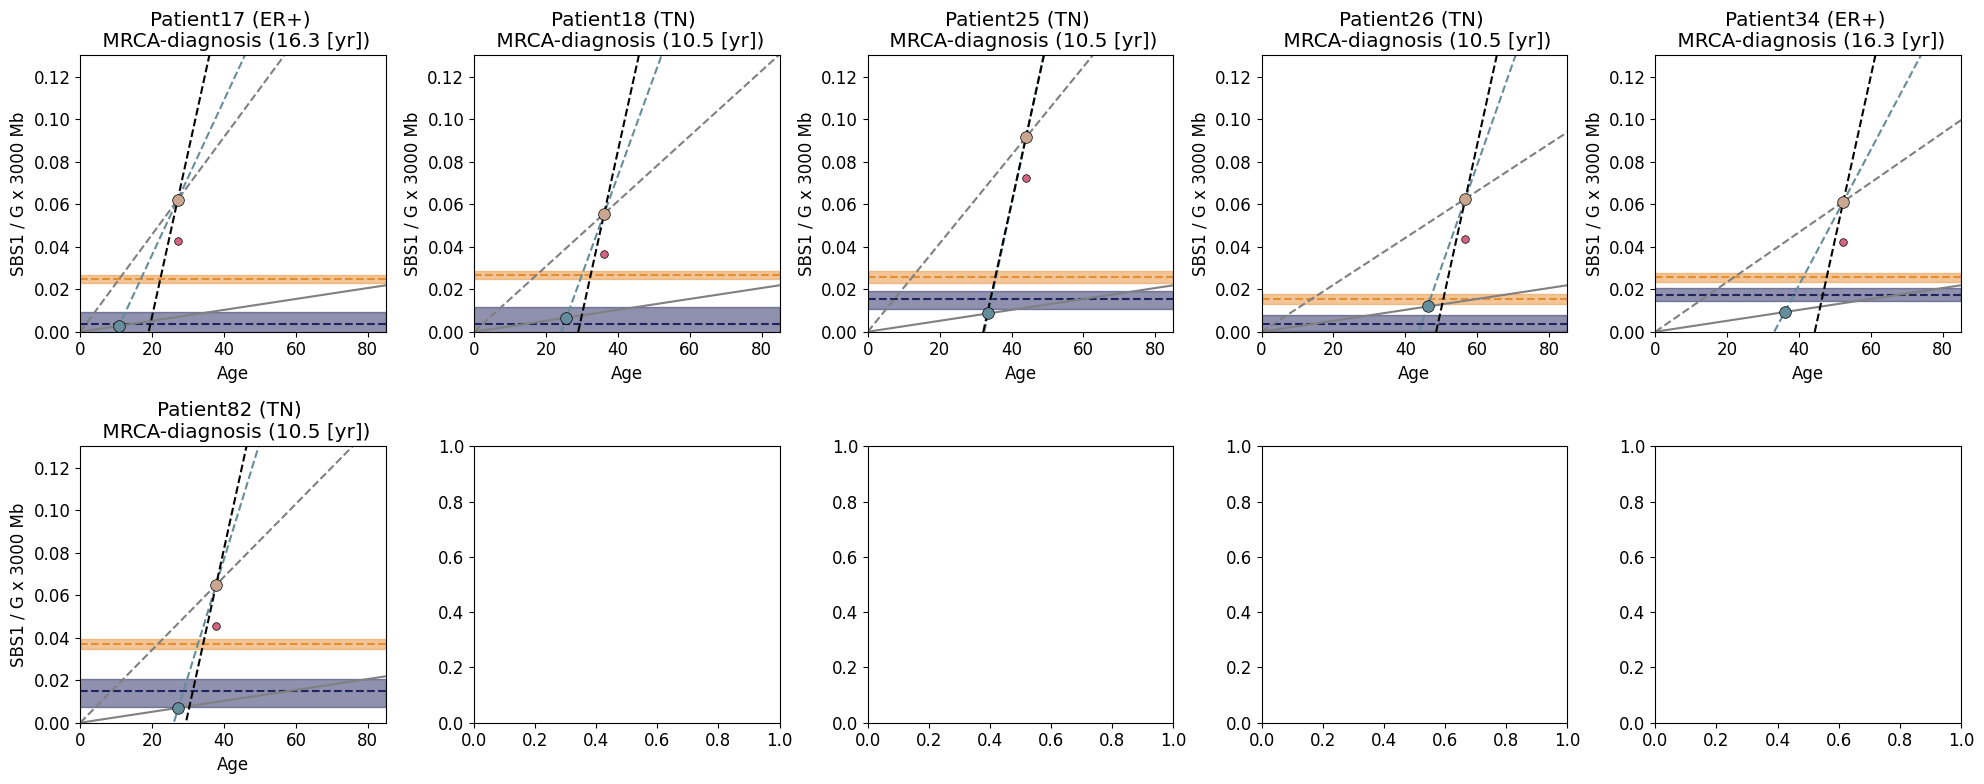

In [17]:
analyze_cohort_timing(
    cohort_name='INFORM',
    bulk_tumor_df=BulkTumor,
    hrd_timer_df=INFORM_merged,
    output_csv='/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/MC_to_Age_results_INFORM.csv',
    output_fig='/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/Age_results_INFORM_finalRun_v2.pdf',
    late_SBS1_burden=0.0191667
)

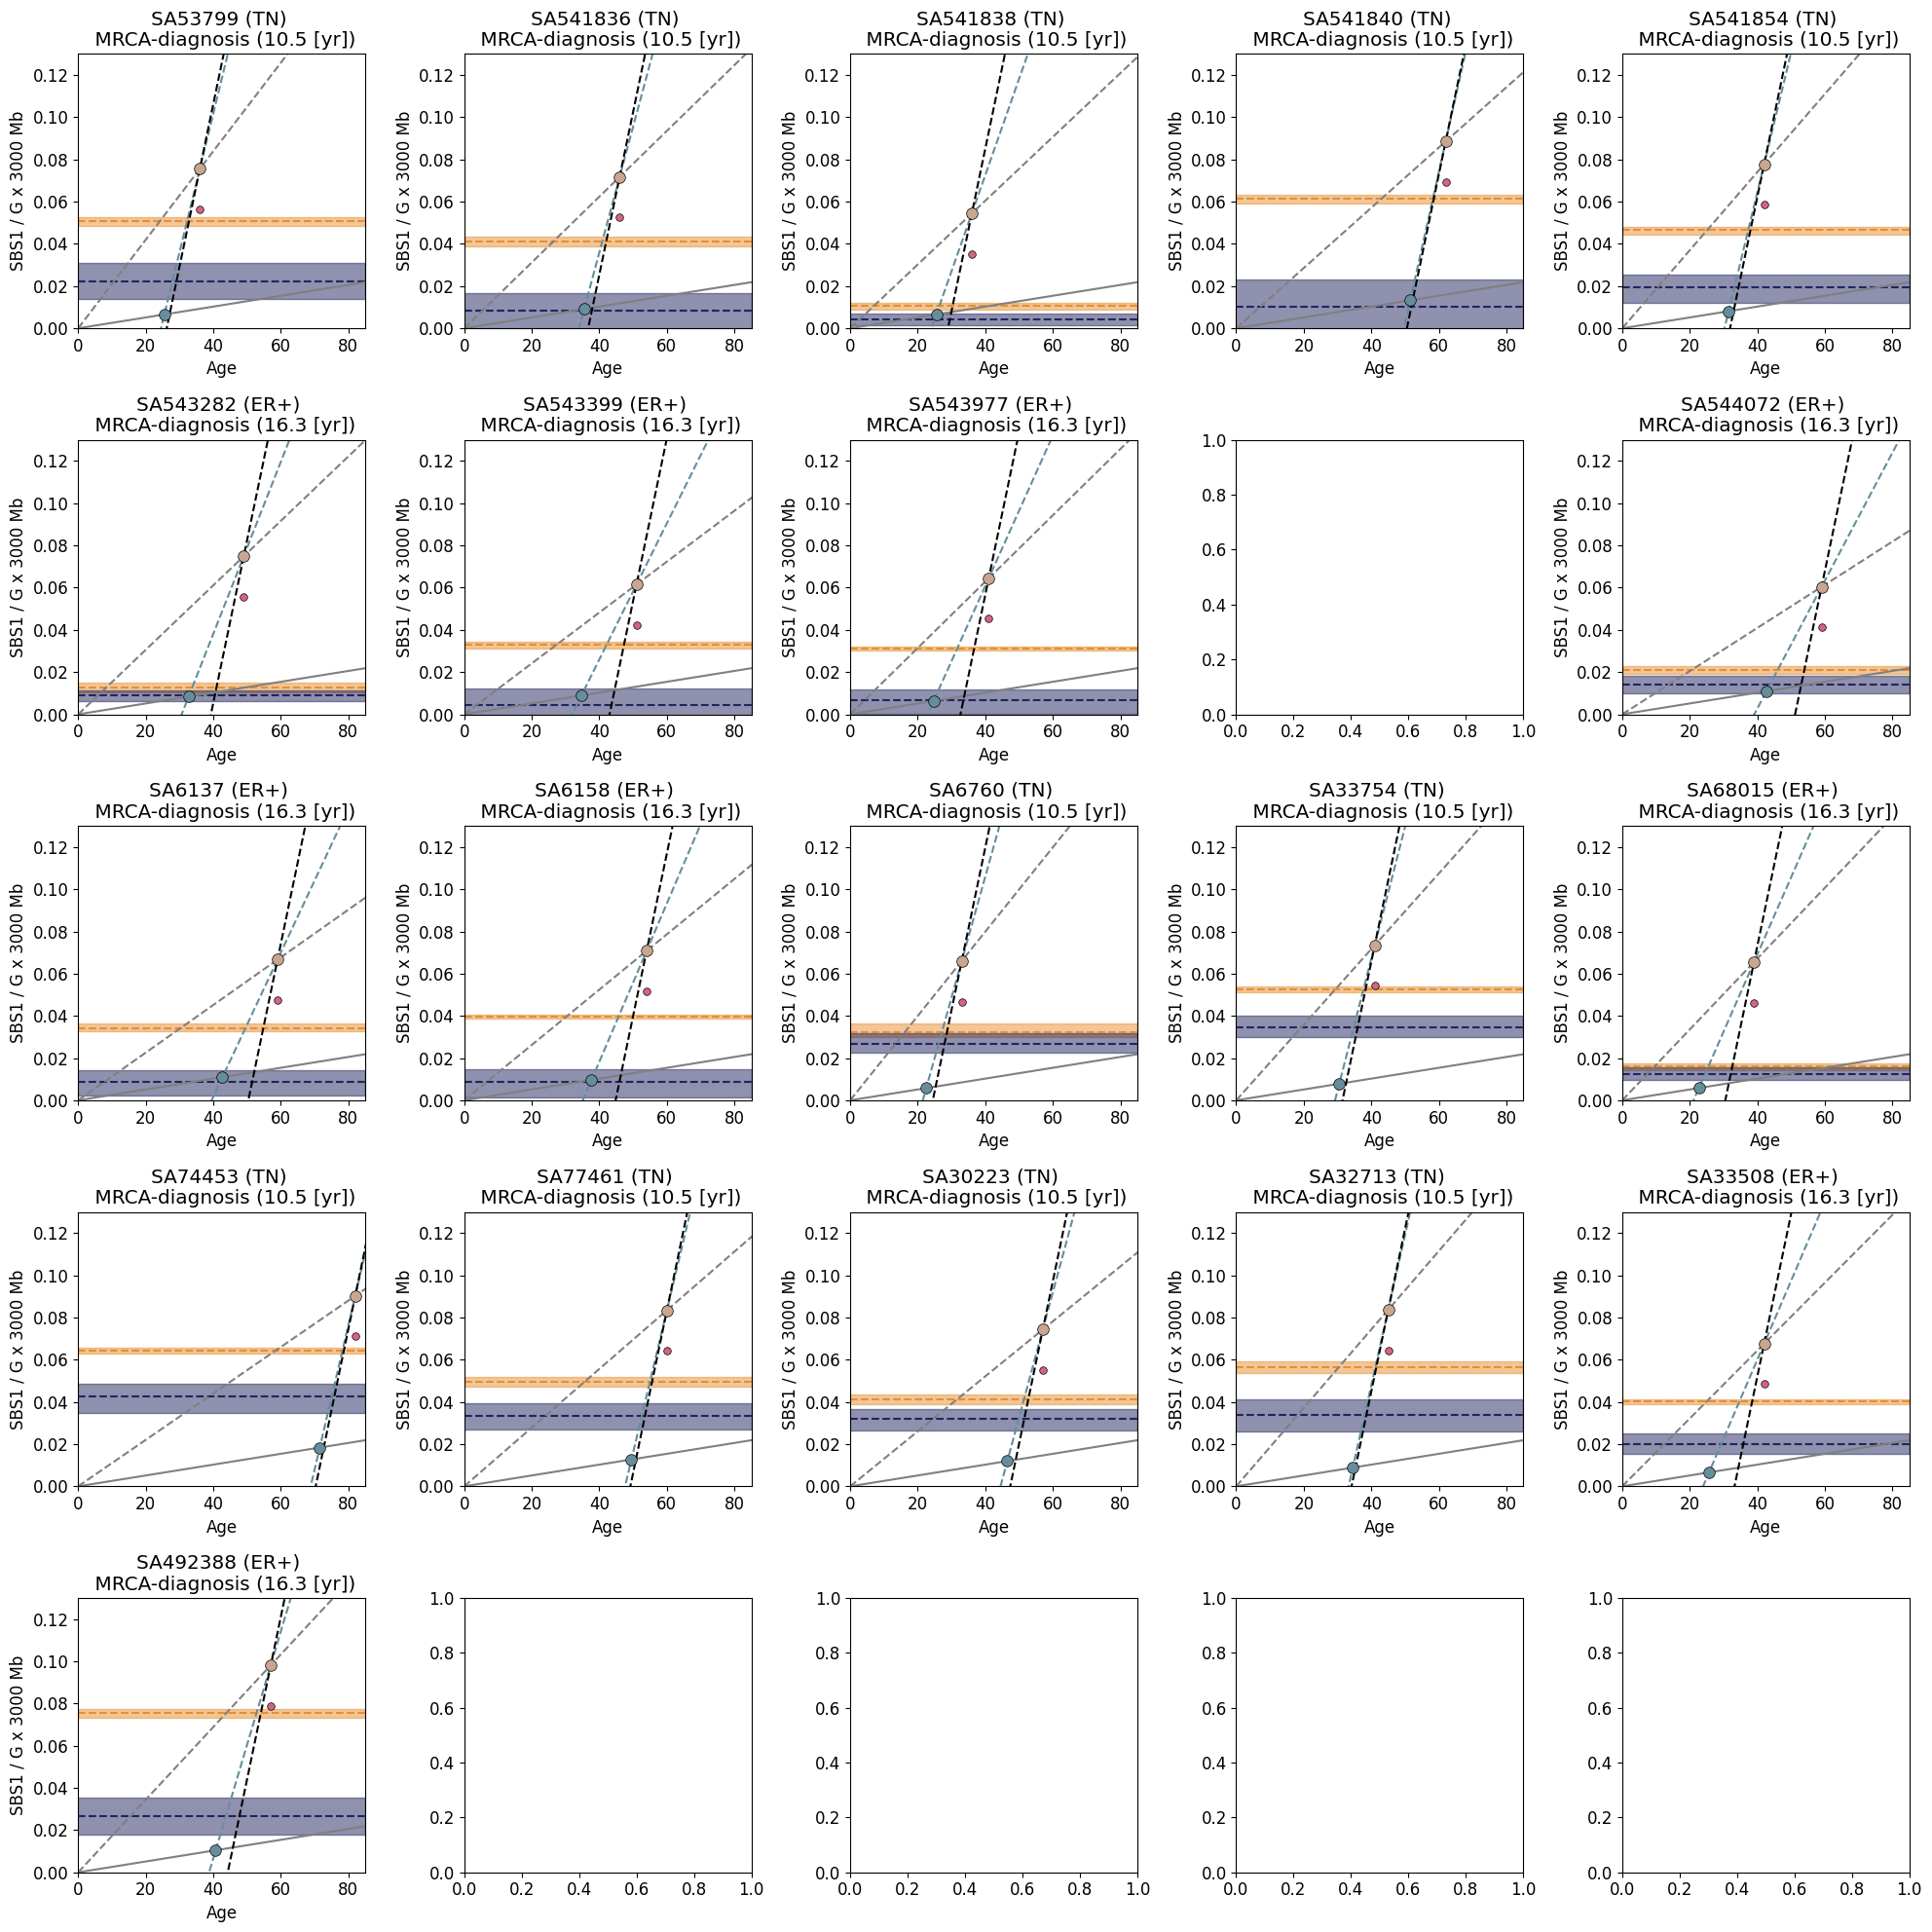

In [18]:
analyze_cohort_timing(
    cohort_name='PCAWG',
    bulk_tumor_df=BulkTumor,
    hrd_timer_df=PCAWG_merged,
    output_csv='/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/MC_to_Age_results_PCAWG.csv',
    output_fig='/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/Age_results_PCAWG_finalRun_v2.pdf',
    late_SBS1_burden=0.0191667
)

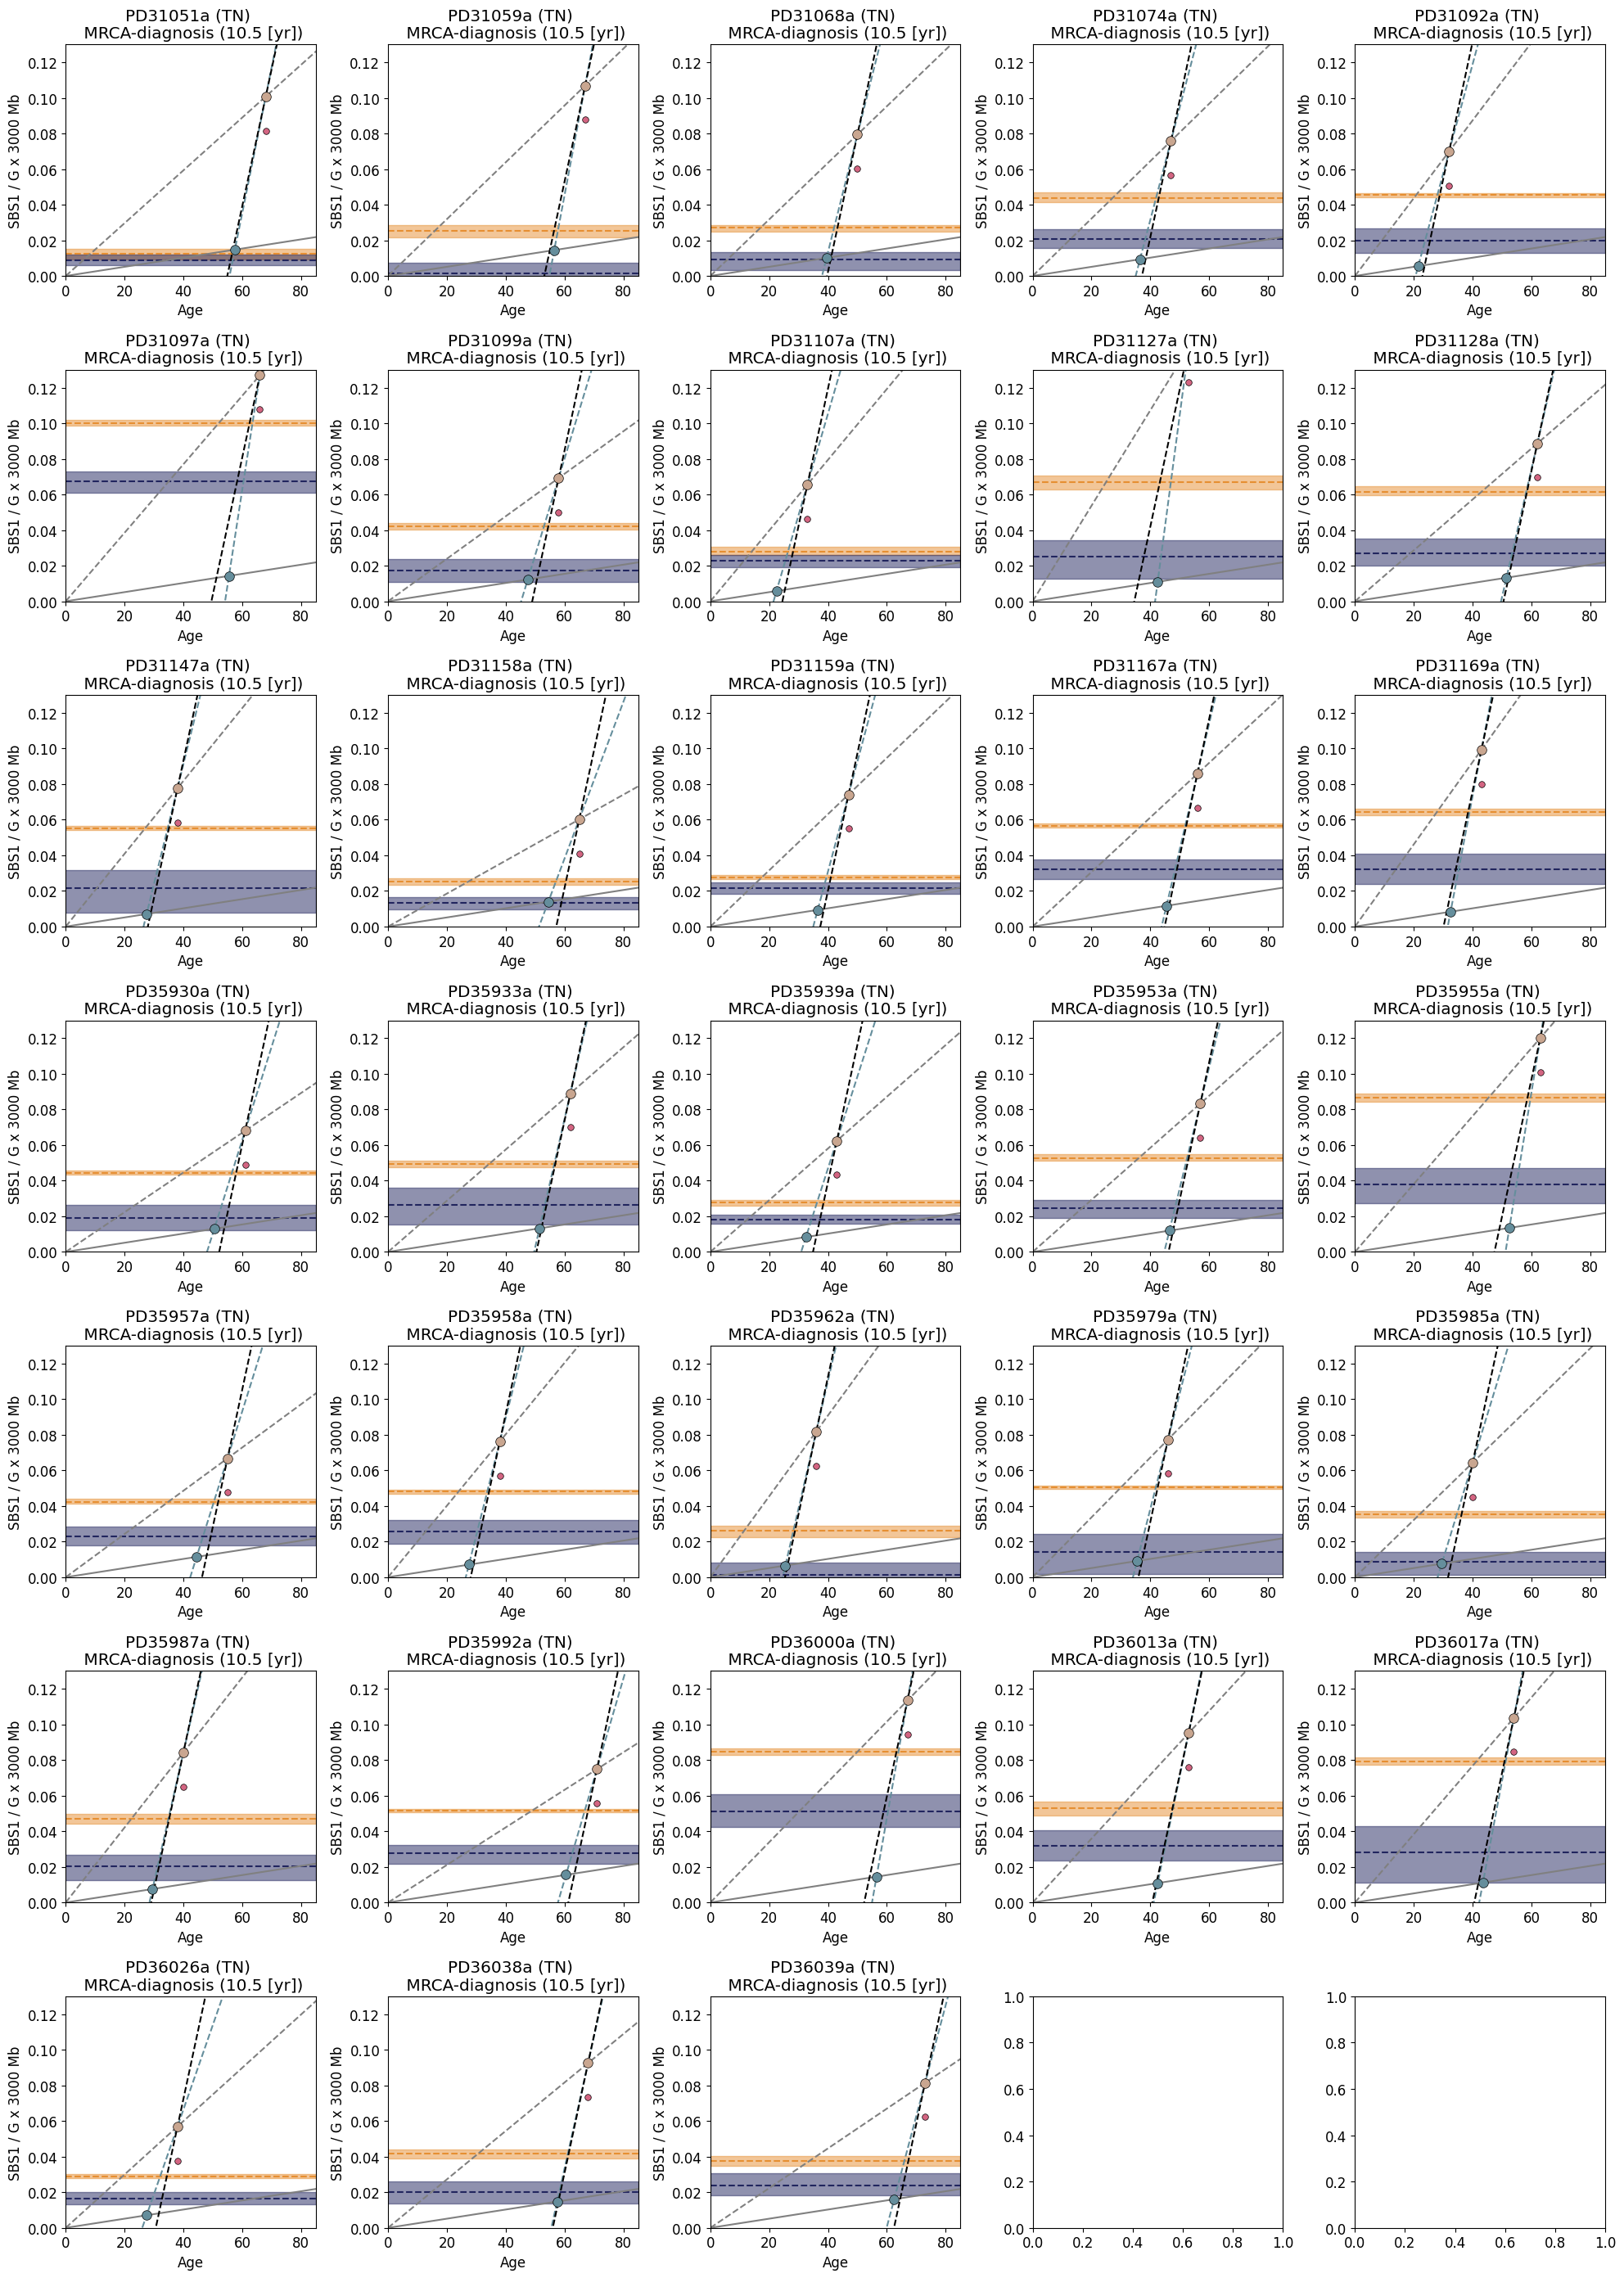

In [19]:
analyze_cohort_timing(
    cohort_name='SCANB',
    bulk_tumor_df=BulkTumor,
    hrd_timer_df=SCANB_merged,
    output_csv='/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/MC_to_Age_results_SCANB.csv',
    output_fig='/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/Age_results_SCANB_finalRun_v2.pdf',
    late_SBS1_burden=0.0191667
)

# OLD RUN

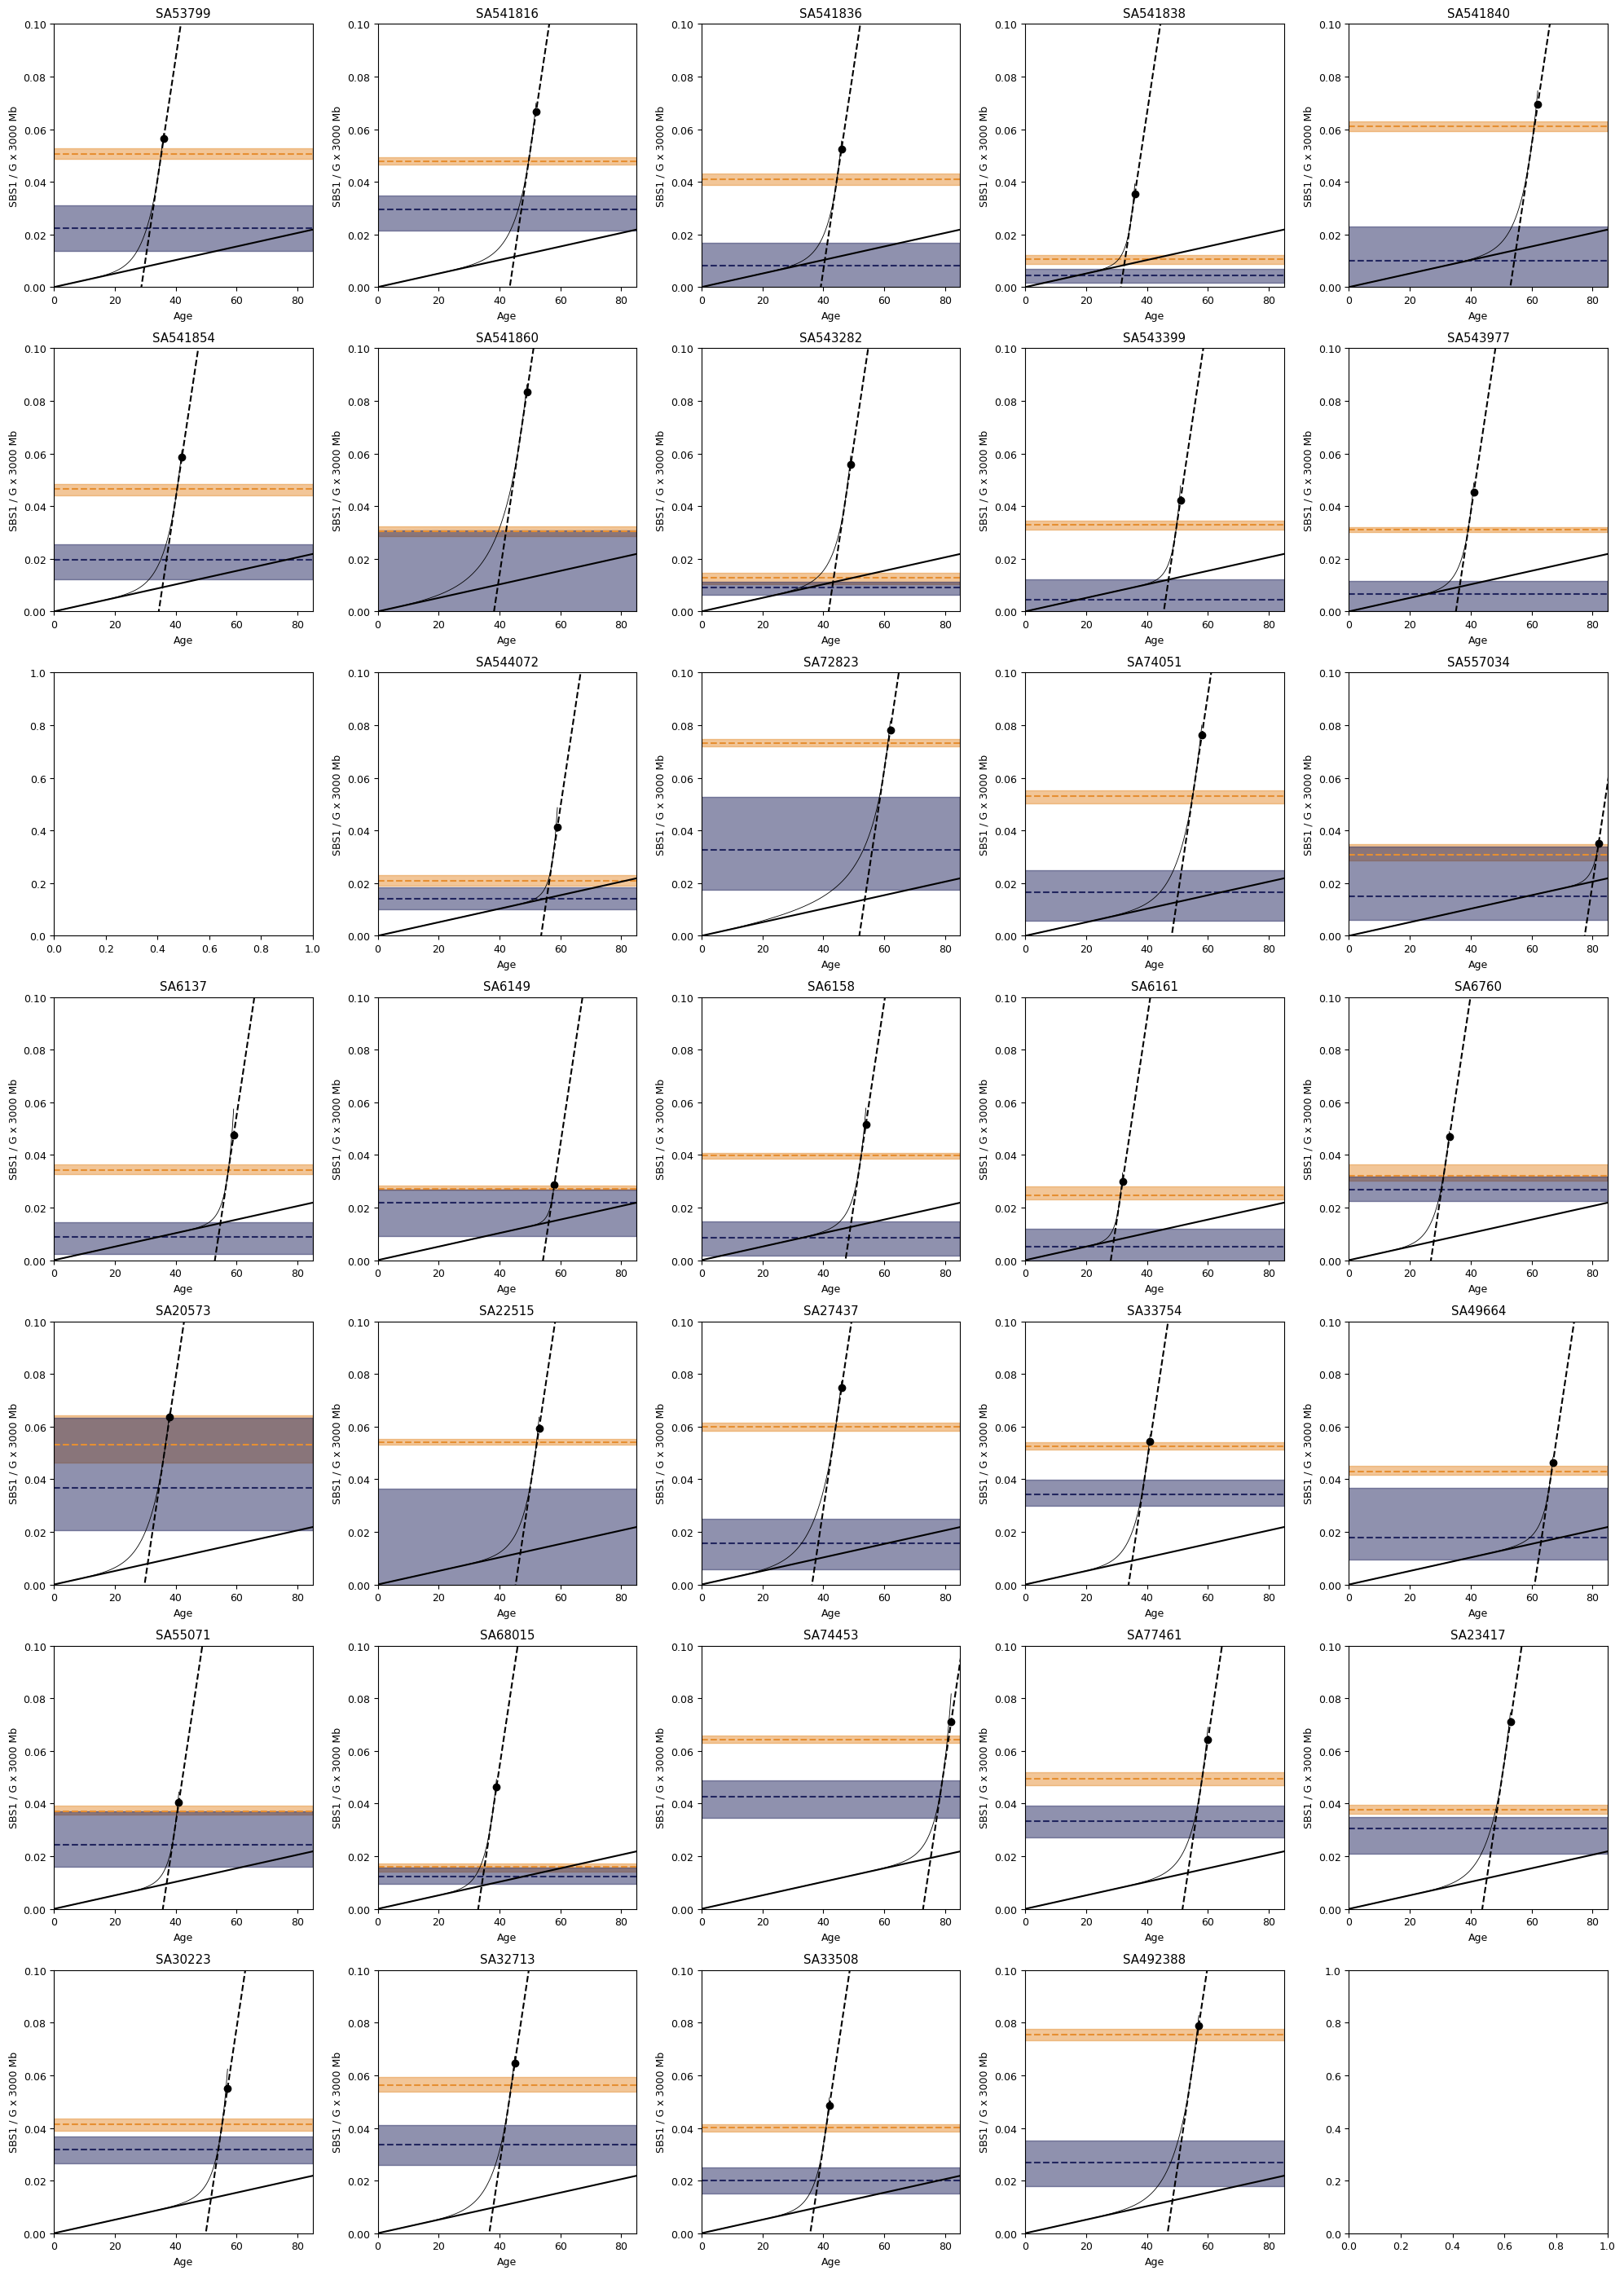

In [3]:
# PCAWG
MolecularTimeToAge.analyze_cohort_timing(
    cohort_name="PCAWG",
    bulk_tumor_df=BulkTumor,
    hrd_timer_df=PCAWG_HRDTimer,
    normal_tissue_df=NormalTissue,
    output_csv="/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/MC_to_Age_results_PCAWG.csv",
    output_fig="/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/Age_results_PCAWG_finalRun.pdf"
)

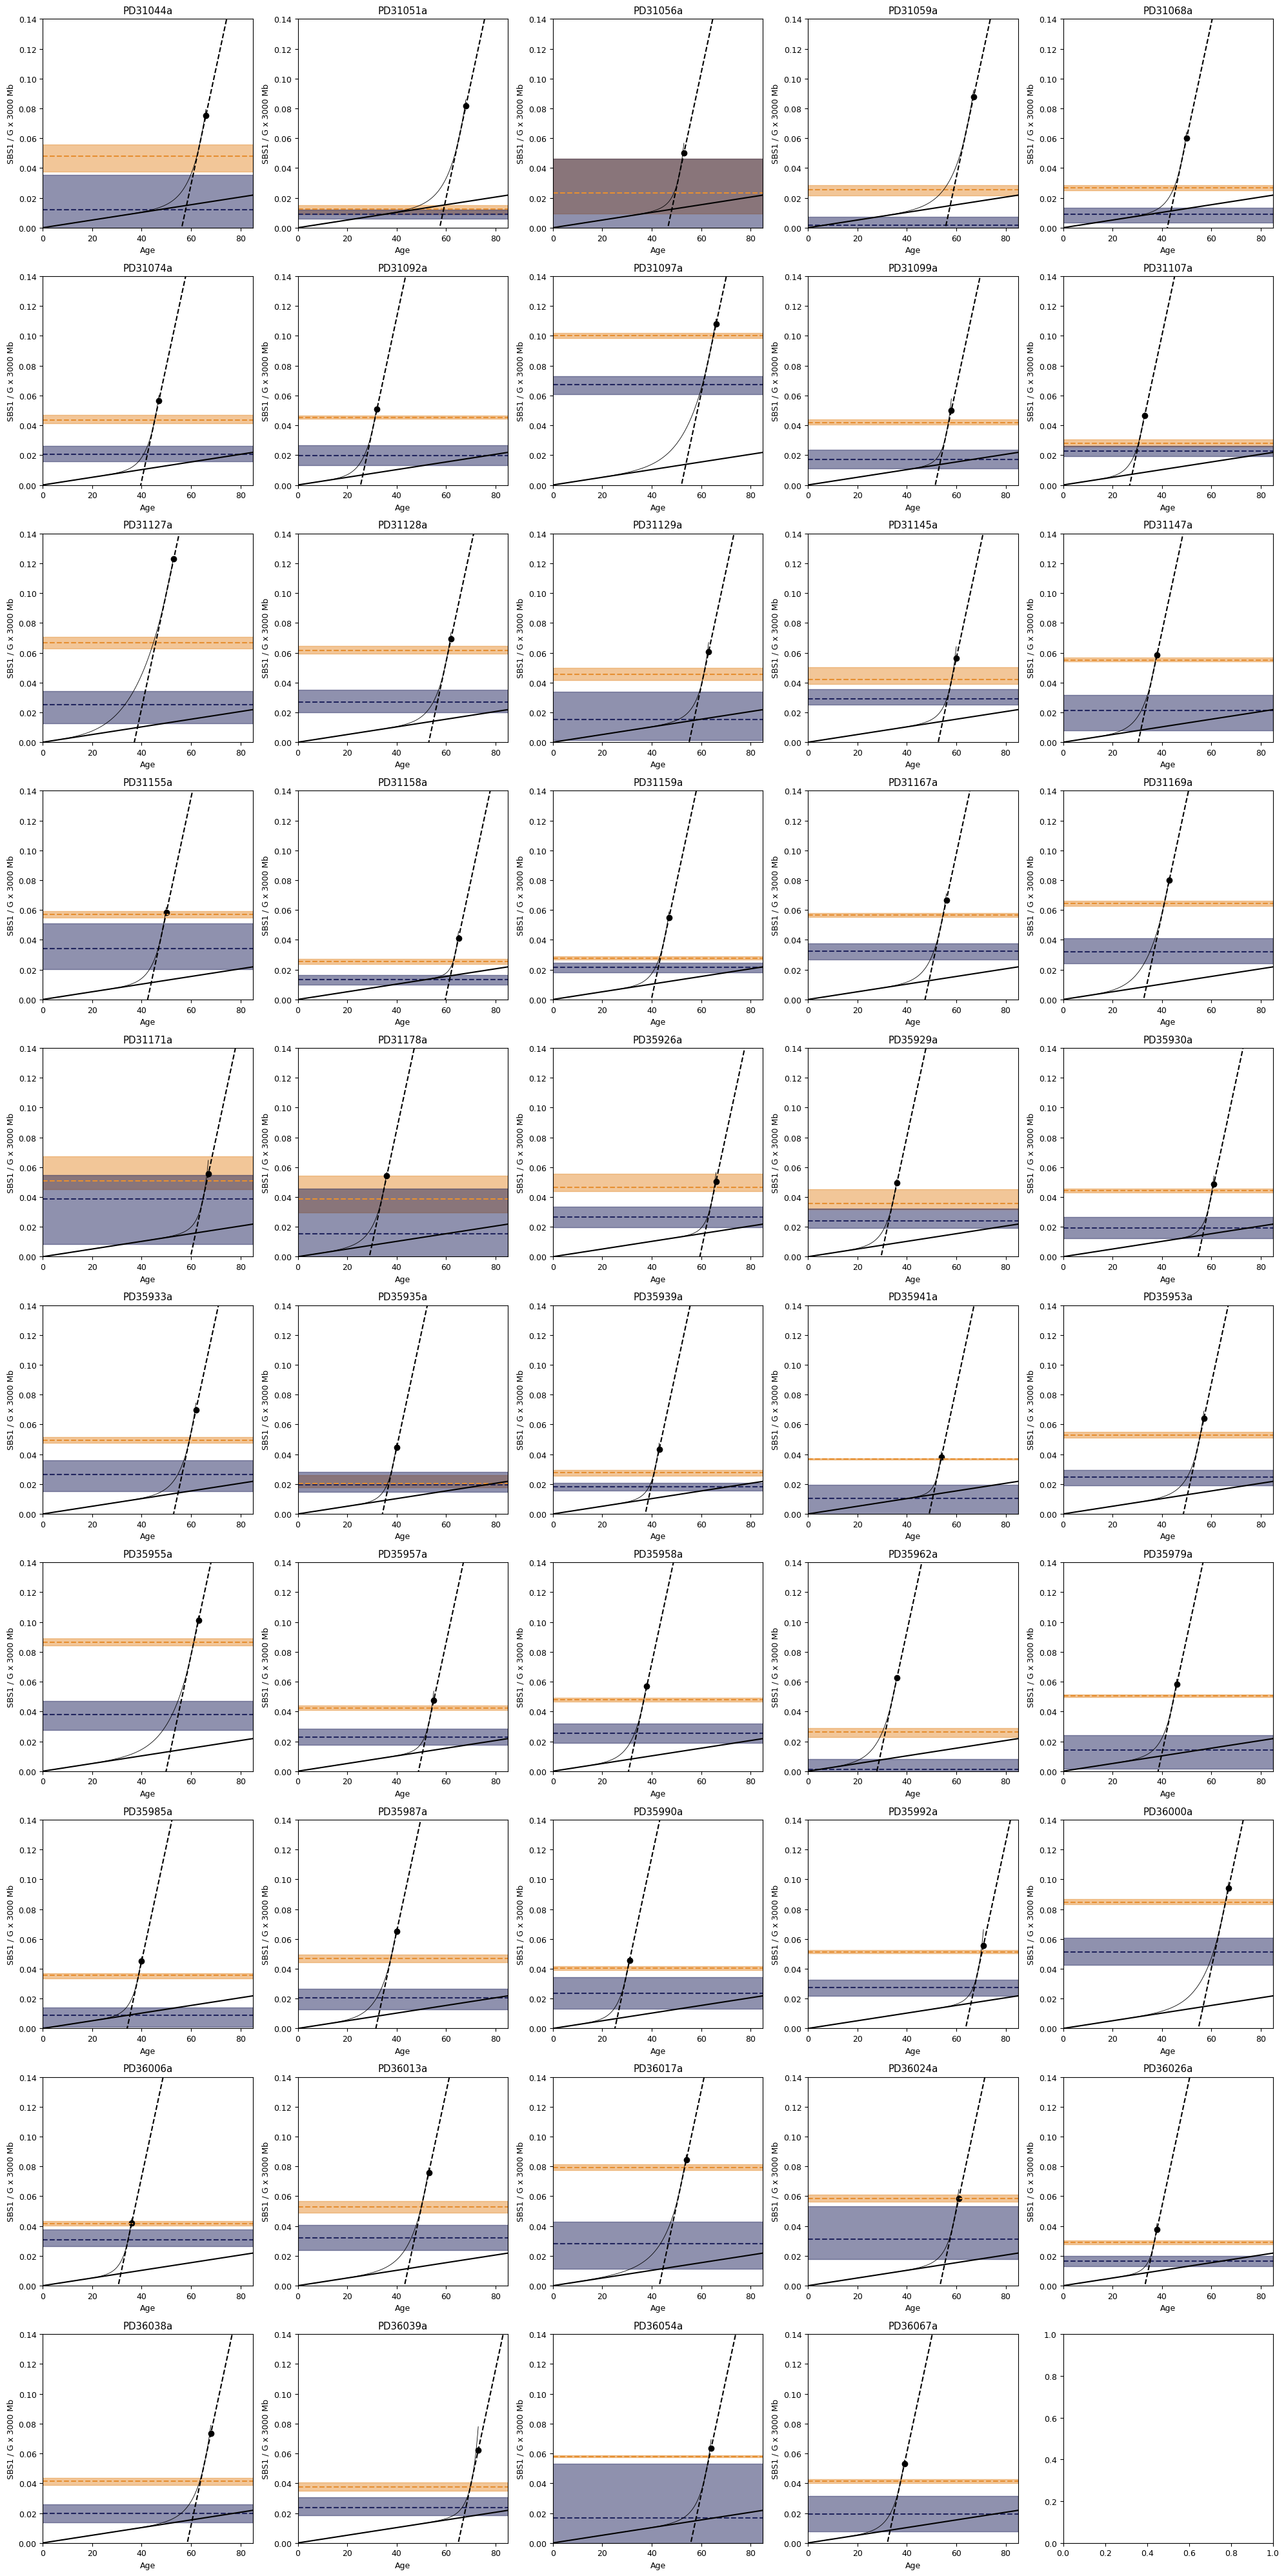

In [3]:
# SCANB
MolecularTimeToAge.analyze_cohort_timing(
    cohort_name="SCANB",
    bulk_tumor_df=BulkTumor,
    hrd_timer_df=SCANB_HRDTimer,
    normal_tissue_df=NormalTissue,
    output_csv="/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/MC_to_Age_results_SCANB.csv",
    output_fig="/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/Age_results_SCANB_finalRun.pdf"
)

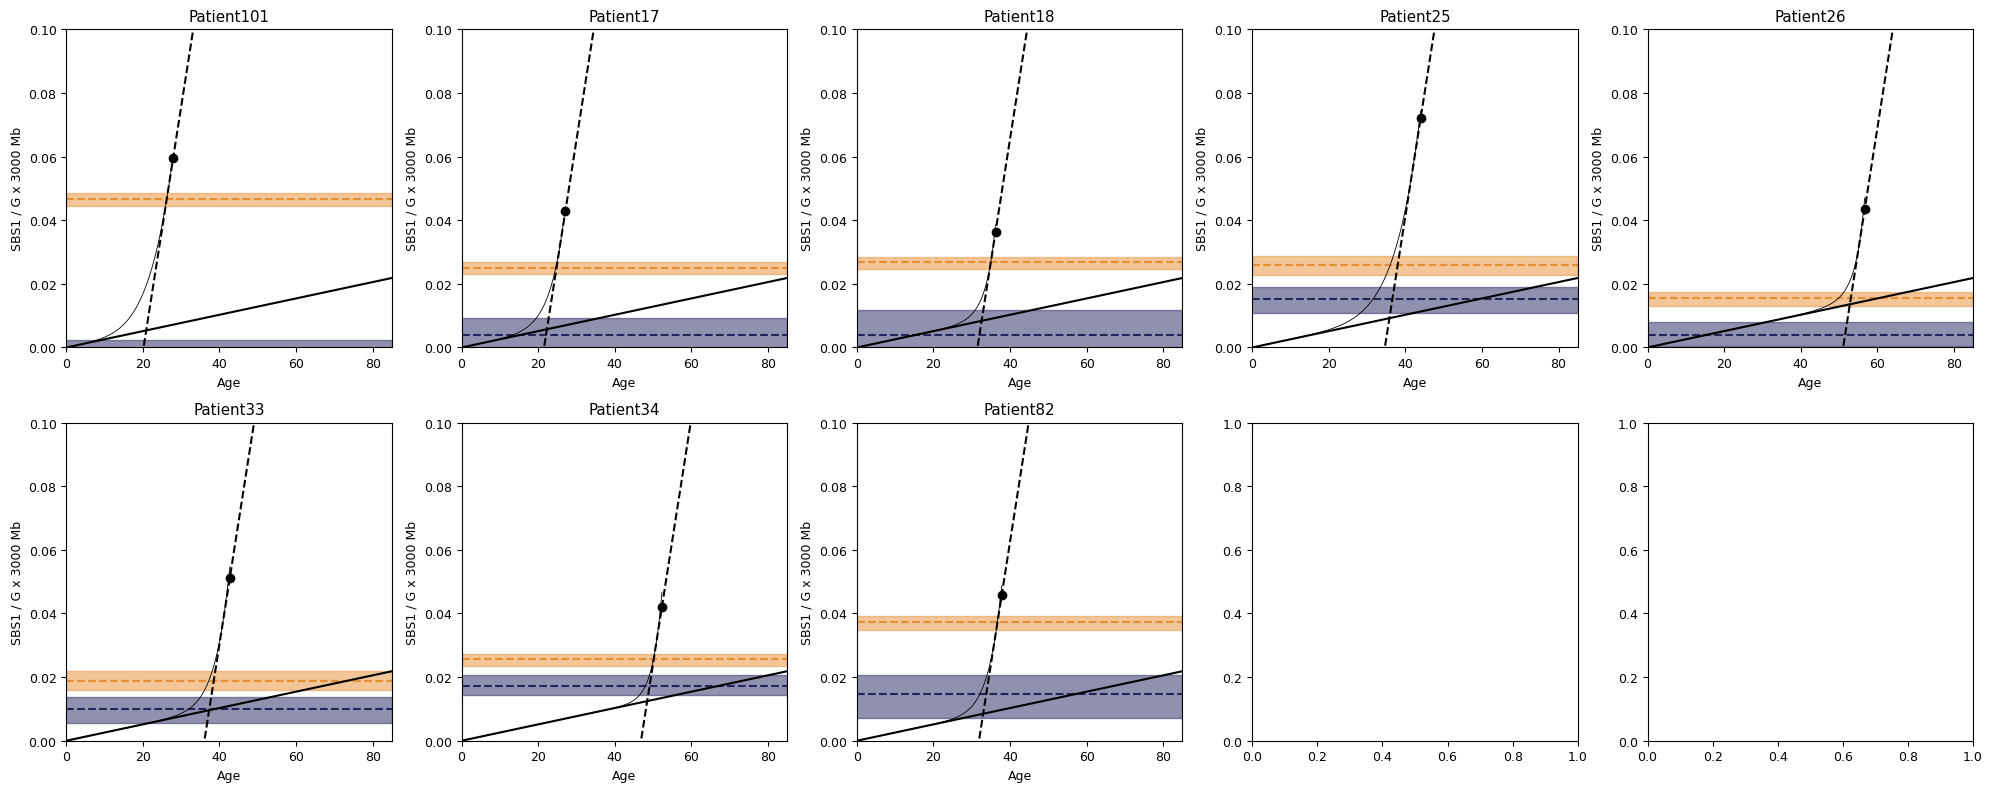

In [3]:
# INFORM
MolecularTimeToAge.analyze_cohort_timing(
    cohort_name="INFORM",
    bulk_tumor_df=BulkTumor,
    hrd_timer_df=INFORM_HRDTimer,
    normal_tissue_df=NormalTissue,
    output_csv="/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/MC_to_Age_results_INFORM.csv",
    output_fig="/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/Age_results_INFORM_finalRun.pdf"
)

# HRD lag figure

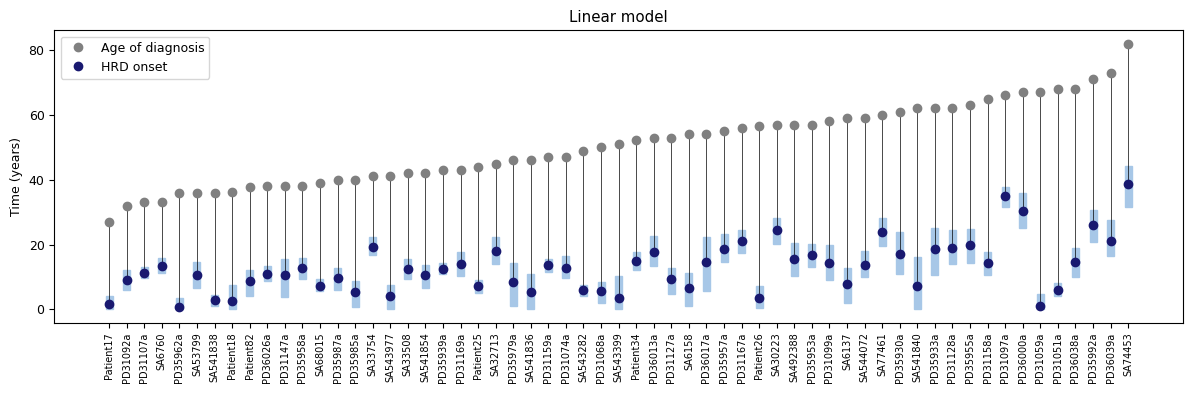

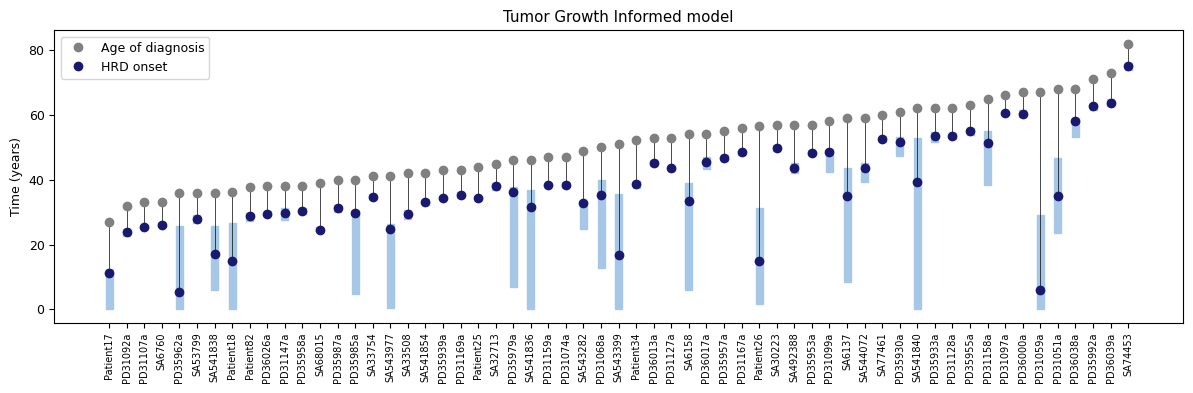

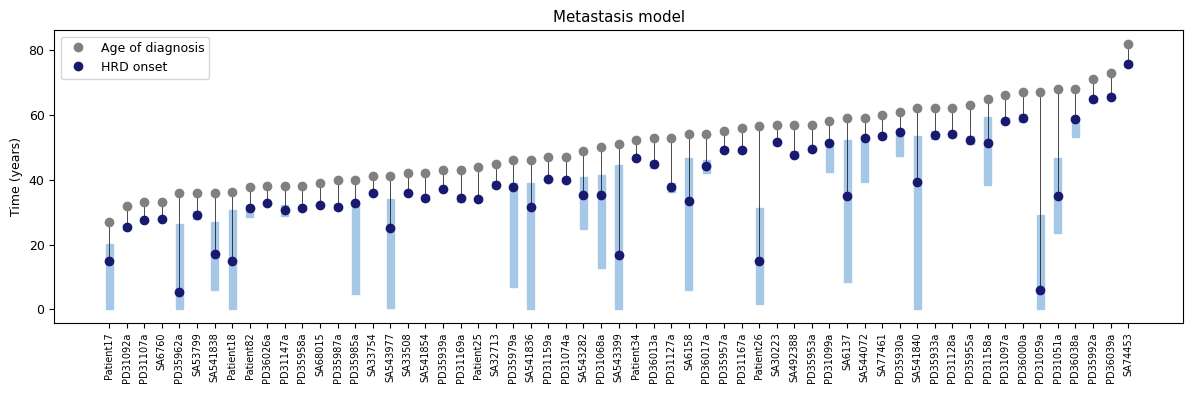

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model(df, meta, model_col_prefix, title, output_file):
    display_labels = df['ID'].map(
        lambda sid: meta.loc[sid, 'sample.display']
        if sid in meta.index and pd.notna(meta.loc[sid, 'sample.display'])
        else sid
    )

    fig, ax = plt.subplots(figsize=(12, 4))
    color = '#A7C7E7'
    bar_width = 0.4

    for i, row in df.iterrows():
        ax.plot([i, i], [row['Age'], row[f'{model_col_prefix}']], color='k', lw=0.5, zorder=1)
        ax.add_patch(
            plt.Rectangle(
                (i - bar_width / 2, row[f'{model_col_prefix}_low']),
                bar_width,
                row[f'{model_col_prefix}_high'] - row[f'{model_col_prefix}_low'],
                color=color,
                alpha=1,
                zorder=0
            )
        )
        ax.plot(i, row['Age'], 'o', color='grey', label='Age of diagnosis' if i == 0 else "", zorder=2)
        ax.plot(i, row[f'{model_col_prefix}'], 'o', color='#191970', label='HRD onset' if i == 0 else "", zorder=3)

    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(display_labels, rotation=90, fontsize=7)
    ax.set_ylabel("Time (years)")
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), loc='upper left')

    plt.tight_layout()
    plt.savefig(output_file, format='pdf', bbox_inches='tight')
    plt.show()

# ---------- DATA LOADING ----------
samples_to_exclude = [
    'PD31145a', 'PD35929a', 'PD36006a', 'PD35926a', 'PD35935a', 'PD36067a', 'PD35990a',
    'PD31129a', 'PD31155a', 'PD35941a', 'PD36024a', 'PD31044a', 'PD31171a', 'PD31178a',
    'PD36054a', 'PD31056a', 
    '7456abd5-303e-4e6f-bf4e-47efefc7310f', 'fc806c50-2f6e-418d-e040-11ac0d485f01',
    '5dbf3203-ce73-41e4-bf9a-32fc856f73f5', '418e916b-7a4e-4fab-8616-15dcec4d79f8',
    'f393bb07-270c-2c93-e040-11ac0d484533', 'b752b444-f033-4be4-9d24-e5e80b4181af',
    '207f8a42-5b05-4876-b0ae-ebfaeea27844', 'd5372745-95cf-4572-a6e7-e7f5b796911a',
    'f393bb0c-4178-ca4a-e040-11ac0d48455f', '987528ac-437a-4eb8-a335-4f2076d5c006',
    'fc8130df-8ec8-5b1e-e040-11ac0d485e06', 'fca6150f-d555-a29e-e040-11ac0d4873b2',
    '43f7a2e0-fec9-4e43-872d-18c6c946fa17', 'Patient33', 'Patient101'
]

metadata_path = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v5.csv"
meta = pd.read_csv(metadata_path)
meta.set_index('sample', inplace=True)

dfs = []
for name in ["INFORM", "PCAWG", "SCANB"]:
    df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/MC_to_Age_results_{name}.csv")
    df['Cohort'] = name
    df.replace("NA", pd.NA, inplace=True)
    df.fillna(0, inplace=True)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all[~df_all['ID'].isin(samples_to_exclude)]
df_all = df_all.sort_values(by='Age').reset_index(drop=True)
df_all = df_all.astype({'Age': float})

# ---------- PLOT CALLS ----------
# Linear model
df_linear = df_all.dropna(subset=['HRD_linear', 'HRD_linear_low', 'HRD_linear_high'])
plot_model(
    df_linear,
    meta,
    model_col_prefix='HRD_linear',
    title='Linear model',
    output_file="/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/Linear_New.pdf"
)

# Tumor Growth Informed model
df_tumor = df_all.dropna(subset=['HRD_norm_int', 'HRD_norm_int_low', 'HRD_norm_int_high'])
plot_model(
    df_tumor,
    meta,
    model_col_prefix='HRD_norm_int',
    title='Tumor Growth Informed model',
    output_file="/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/TumorGrowthModel_New.pdf"
)

# Metastasis model
df_mets = df_all.dropna(subset=['HRD_norm_max', 'HRD_norm_max_low', 'HRD_norm_max_high'])
plot_model(
    df_mets,
    meta,
    model_col_prefix='HRD_norm_max',
    title='Metastasis model',
    output_file="/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/MaxMetsModel_New.pdf"
)


In [100]:
sample_order = [x.get_text() for x in ax.get_xticklabels()]

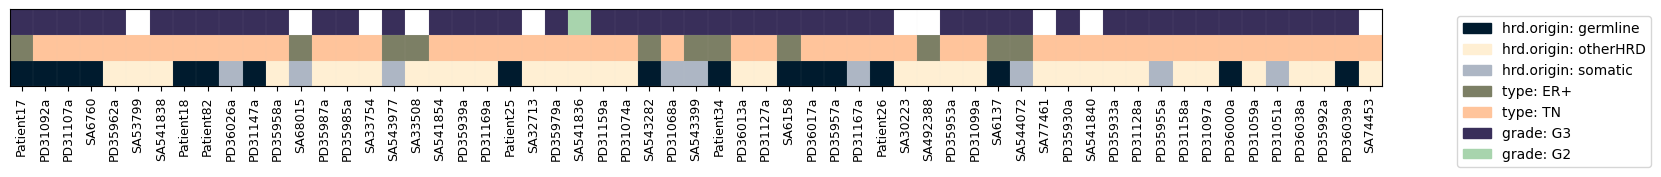

In [122]:
import matplotlib.patches as patches  
import pandas as pd
import matplotlib.pyplot as plt

# Load metadata and map display names to index
metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v5.csv")
metadata.set_index("sample", inplace=True)
display_to_index = metadata['sample.display'].dropna().to_dict()
index_by_display = {v: k for k, v in display_to_index.items()}

# Reorder metadata using sample.display values in sample_order
metadata = metadata.loc[[index_by_display[s] for s in sample_order if s in index_by_display]]

annotations, offsets = ['hrd.origin', 'type', 'grade'], [0.5, 1.5, 2.5, 3.5]
row_colors = {
    'hrd.origin': ['#001B2E', '#FFEFD3', '#ADB6C4', 'grey'],
    'type': ['#7C7F65', '#FFC49B', '#70566D'],
    'grade': ['#392F5A', '#A8D4AD', 'brown']
}

fig, ax = plt.subplots(figsize=(len(sample_order) * 0.3, 1))
ax.set_xticks(range(len(sample_order)))
ax.set_xticklabels(sample_order, rotation=90)

for i, display_name in enumerate(sample_order):
    if display_name not in index_by_display:
        continue
    sample = index_by_display[display_name]
    for j, col in enumerate(annotations):
        val = metadata.at[sample, col]
        color = row_colors[col][list(metadata[col].dropna().unique()).index(val)] if pd.notna(val) else "white"
        ax.add_patch(patches.Rectangle((i - 0.5, offsets[j]), 1, 1, color=color, linewidth=0.05))

for i in range(len(sample_order) + 1): ax.axvline(x=i - 0.5, color='lightgrey', linewidth=0.05)
for j in offsets: ax.axhline(y=j, color='lightgrey', linewidth=0.05)

ax.set_yticks([])

patches_list = [
    patches.Patch(color=row_colors[col][idx], label=f'{col}: {val}')
    for col in annotations
    for idx, val in enumerate(metadata[col].dropna().unique())
]
ax.legend(handles=patches_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

ax.set_ylim(0.5, offsets[-1])
ax.set_xlim(-0.5, len(sample_order) - 0.5)
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/meta_hrdlag.pdf", format='pdf', bbox_inches='tight')
plt.show()


Median lag values:
  Linear: 36.66
  Metastasis: 7.72
  Tumor Growth: 9.08

Mann-Whitney U test p-values:
  Linear vs Tumor Growth: 1.8320e-17
  Linear vs Metastasis: 1.8320e-17
  Tumor Growth vs Metastasis: 5.5266e-03


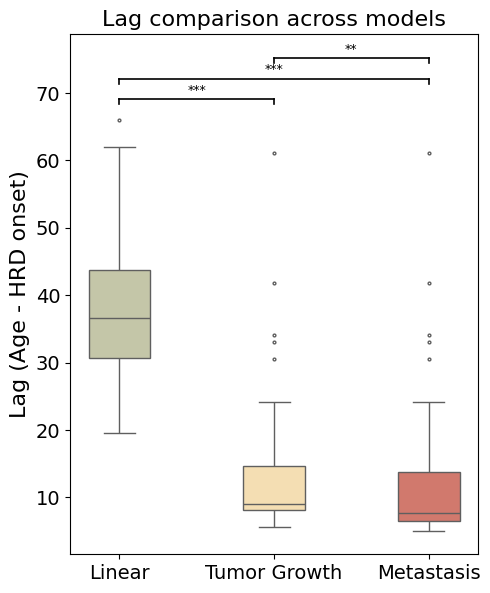

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def pval_to_stars(p):
    if p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return 'ns'

# Load data
dfs = []
for name in ["INFORM", "PCAWG", "SCANB"]:
    df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/MC_to_Age_results_{name}.csv")
    df['Cohort'] = name
    df.replace("NA", pd.NA, inplace=True)
    df.fillna(0, inplace=True)
    dfs.append(df)

df_all = pd.concat(dfs).sort_values('Age').reset_index(drop=True)
df_all = df_all.astype({'Age': float})

# Calculate lag for each model
lag_linear = df_all[['Age', 'HRD_linear']].copy()
lag_linear['lag'] = lag_linear['Age'] - lag_linear['HRD_linear']
lag_linear['Model'] = 'Linear'

lag_tumor = df_all[['Age', 'HRD_norm_int']].copy()
lag_tumor['lag'] = lag_tumor['Age'] - lag_tumor['HRD_norm_int']
lag_tumor['Model'] = 'Tumor Growth'

lag_mets = df_all[['Age', 'HRD_norm_max']].copy()
lag_mets['lag'] = lag_mets['Age'] - lag_mets['HRD_norm_max']
lag_mets['Model'] = 'Metastasis'

# Combine for plotting
df_lag_all = pd.concat([lag_linear, lag_tumor, lag_mets])

# Print medians
print("Median lag values:")
for model_name, group in df_lag_all.groupby('Model'):
    median_val = group['lag'].median()
    print(f"  {model_name}: {median_val:.2f}")

# Statistical tests
pvals = {}
pvals['Linear vs Tumor Growth'] = mannwhitneyu(lag_linear['lag'], lag_tumor['lag'], alternative='two-sided').pvalue
pvals['Linear vs Metastasis'] = mannwhitneyu(lag_linear['lag'], lag_mets['lag'], alternative='two-sided').pvalue
pvals['Tumor Growth vs Metastasis'] = mannwhitneyu(lag_tumor['lag'], lag_mets['lag'], alternative='two-sided').pvalue

print("\nMann-Whitney U test p-values:")
for comp, p in pvals.items():
    print(f"  {comp}: {p:.4e}")

# Plot order and colors
order = ['Linear', 'Tumor Growth', 'Metastasis']
palette = ["#c9cba3", "#ffe1a8", "#e26d5c"]

plt.figure(figsize=(5, 6))
ax = sns.boxplot(
    data=df_lag_all, x='Model', y='lag',
    order=order,
    palette=palette,
    hue='Model',
    width=0.4, fliersize=2, linewidth=1
)

plt.ylabel('Lag (Age - HRD onset)', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Lag comparison across models", fontsize=16)

# Coordinates for box centers
positions = range(len(order))

# Calculate max lag to place the significance lines above
y_max = df_lag_all['lag'].max()
y_min = df_lag_all['lag'].min()
y_range = y_max - y_min
line_offset = y_range * 0.05  # vertical space between lines

# Define comparisons to annotate: (box1_idx, box2_idx, label)
comparisons = [
    (0, 1, 'Linear vs Tumor Growth'),
    (0, 2, 'Linear vs Metastasis'),
    (1, 2, 'Tumor Growth vs Metastasis'),
]

# Start height for first line
line_height = y_max + line_offset

for i, (x1, x2, comp) in enumerate(comparisons):
    p = pvals[comp]
    stars = pval_to_stars(p)

    # Draw horizontal line
    ax.plot([x1, x2], [line_height, line_height], color='black', lw=1.2)
    # Draw vertical ticks
    ax.plot([x1, x1], [line_height, line_height - line_offset/4], color='black', lw=1.2)
    ax.plot([x2, x2], [line_height, line_height - line_offset/4], color='black', lw=1.2)

    # Add stars text in the middle with smaller font
    ax.text((x1 + x2) / 2, line_height + line_offset / 10, stars,
            ha='center', va='bottom', fontsize=9, color='black')  # smaller fontsize

    # Increase height for next line
    line_height += line_offset


plt.tight_layout()
# plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/Lag_Comparison_All_Models_with_stars.pdf", format='pdf', bbox_inches='tight')
plt.show()


0.29327072669776244
0.00029458014258526625
0.29327072669776244


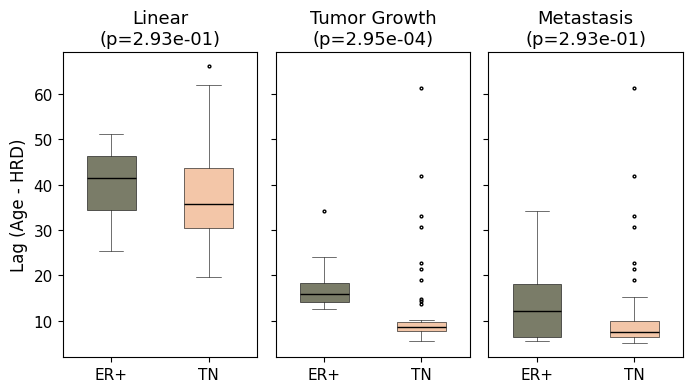

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ranksums

# Load metadata
metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v5.csv").set_index("sample")

def load_lag_data(model):
    dfs = []
    for name in ["INFORM", "PCAWG", "SCANB"]:
        df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/MC_to_Age_results_{name}.csv")
        df['Cohort'] = name
        df.replace("NA", pd.NA, inplace=True)
        df.fillna(0, inplace=True)
        dfs.append(df)
    df_all = pd.concat(dfs).sort_values('Age').reset_index(drop=True)
    
    df_all = df_all.astype({'Age': float})
    
    if model == "Linear":
        df_all = df_all.astype({'HRD_linear': float})
        df_all['lag'] = df_all['Age'] - df_all['HRD_linear']
    elif model == "Tumor Growth":
        df_all = df_all.astype({'HRD_norm_int': float})
        df_all['lag'] = df_all['Age'] - df_all['HRD_norm_int']
    elif model == "Metastasis":
        df_all = df_all.astype({'HRD_norm_max': float})
        df_all['lag'] = df_all['Age'] - df_all['HRD_norm_max']
    else:
        raise ValueError("Unknown model")
        
    df_all['Model'] = model
    return df_all

# Load data for all models
df_linear = load_lag_data("Linear")
df_tumor = load_lag_data("Tumor Growth")
df_mets = load_lag_data("Metastasis")

# Combine and join with metadata
combined = pd.concat([df_linear[['ID', 'lag', 'Model']],
                      df_tumor[['ID', 'lag', 'Model']],
                      df_mets[['ID', 'lag', 'Model']]])

combined = combined.set_index('ID').join(metadata[['type']]).reset_index()
combined = combined[combined['type'].isin(['ER+', 'TN'])]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(7, 4), sharey=True)

model_order = ['Linear', 'Tumor Growth', 'Metastasis']
palette = {'ER+': '#7C7F65', 'TN': '#FFC49B'}

for i, model in enumerate(model_order):
    df_model = combined[combined['Model'] == model]
    er_lag = df_model[df_model['type'] == 'ER+']['lag']
    tn_lag = df_model[df_model['type'] == 'TN']['lag']
    #p = mannwhitneyu(er_lag, tn_lag, alternative='two-sided').pvalue
    stat, p = ranksums(er_lag, tn_lag)
    #print(f"{model} summary:")
    #print(df_model.groupby('type')['lag'].describe())
    #print(f"{model} ER+ median: {er_lag.median()}, TN median: {tn_lag.median()}\n")

    print(p)
    
    sns.boxplot(data=df_model, x='type', hue='type', y='lag',
                order=['ER+', 'TN'],
                palette=palette,
                ax=axes[i], width=0.5, fliersize=2, legend=False,
                boxprops=dict(edgecolor='black', linewidth=0.4),
                whiskerprops=dict(color='black', linewidth=0.4),
                capprops=dict(color='black', linewidth=0.4),
                medianprops=dict(color='black'),
                flierprops=dict(markeredgecolor='black', linewidth=0.5))
    
    axes[i].set_title(f'{model}\n(p={p:.2e})', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Lag (Age - HRD)', fontsize=12)
    axes[i].tick_params(labelsize=11)

plt.tight_layout()
plt.show()


ER+ (Tumor Growth) - Median: 16.01, IQR: (14.16, 18.46), IQR range: 4.30
TN (Tumor Growth) - Median: 8.62, IQR: (7.84, 9.73), IQR range: 1.89
ER+ (Metastasis) - Median: 12.23, IQR: (6.53, 18.20), IQR range: 11.67
TN (Metastasis) - Median: 7.58, IQR: (6.50, 10.07), IQR range: 3.58


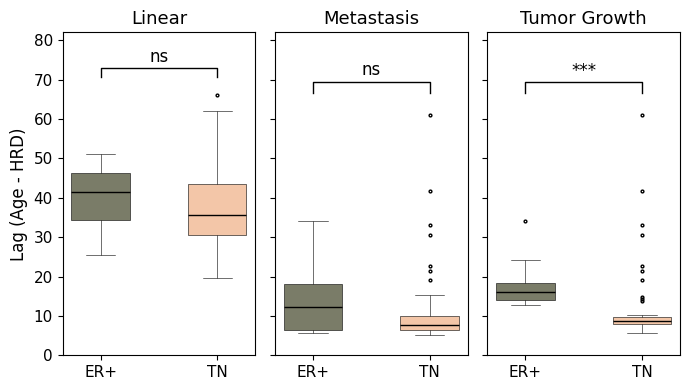

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums

# Load metadata
metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v5.csv").set_index("sample")

def load_lag_data(model):
    dfs = []
    for name in ["INFORM", "PCAWG", "SCANB"]:
        df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/MC_to_Age_results_{name}.csv")
        df['Cohort'] = name
        df.replace("NA", pd.NA, inplace=True)
        df.fillna(0, inplace=True)
        dfs.append(df)
    df_all = pd.concat(dfs).sort_values('Age').reset_index(drop=True)
    df_all = df_all.astype({'Age': float})
    
    if model == "Linear":
        df_all = df_all.astype({'HRD_linear': float})
        df_all['lag'] = df_all['Age'] - df_all['HRD_linear']
    elif model == "Tumor Growth":
        df_all = df_all.astype({'HRD_norm_int': float})
        df_all['lag'] = df_all['Age'] - df_all['HRD_norm_int']
    elif model == "Metastasis":
        df_all = df_all.astype({'HRD_norm_max': float})
        df_all['lag'] = df_all['Age'] - df_all['HRD_norm_max']
    else:
        raise ValueError("Unknown model")
        
    df_all['Model'] = model
    return df_all

# Load data
df_linear = load_lag_data("Linear")
df_tumor = load_lag_data("Tumor Growth")

# Join with metadata and filter for ER+ and TN
df_tumor_type = df_tumor.set_index('ID').join(metadata[['type']]).reset_index()
df_tumor_type = df_tumor_type[df_tumor_type['type'].isin(['ER+', 'TN'])]

# Calculate median and IQR for each type
for tumor_type in ['ER+', 'TN']:
    lag_values = df_tumor_type[df_tumor_type['type'] == tumor_type]['lag']
    median = lag_values.median()
    q1 = lag_values.quantile(0.25)
    q3 = lag_values.quantile(0.75)
    iqr = q3 - q1
    print(f"{tumor_type} (Tumor Growth) - Median: {median:.2f}, IQR: ({q1:.2f}, {q3:.2f}), IQR range: {iqr:.2f}")
    print(" =================================================================")

df_mets = load_lag_data("Metastasis")

# Join with metadata and filter for ER+ and TN
df_mets_type = df_mets.set_index('ID').join(metadata[['type']]).reset_index()
df_mets_type = df_mets_type[df_mets_type['type'].isin(['ER+', 'TN'])]

# Calculate median and IQR for each type
for tumor_type in ['ER+', 'TN']:
    lag_values = df_mets_type[df_mets_type['type'] == tumor_type]['lag']
    median = lag_values.median()
    q1 = lag_values.quantile(0.25)
    q3 = lag_values.quantile(0.75)
    iqr = q3 - q1
    print(f"{tumor_type} (Metastasis) - Median: {median:.2f}, IQR: ({q1:.2f}, {q3:.2f}), IQR range: {iqr:.2f}")
    print(" =================================================================")


# Combine and join with metadata
combined = pd.concat([df_linear[['ID', 'lag', 'Model']],
                      df_tumor[['ID', 'lag', 'Model']],
                      df_mets[['ID', 'lag', 'Model']]])

combined = combined.set_index('ID').join(metadata[['type']]).reset_index()
combined = combined[combined['type'].isin(['ER+', 'TN'])]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(7, 4), sharey=True)
model_order = ['Linear', 'Metastasis', 'Tumor Growth']
palette = {'ER+': '#7C7F65', 'TN': '#FFC49B'}

def get_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

for i, model in enumerate(model_order):
    df_model = combined[combined['Model'] == model]
    er_lag = df_model[df_model['type'] == 'ER+']['lag']
    tn_lag = df_model[df_model['type'] == 'TN']['lag']
    stat, p = ranksums(er_lag, tn_lag)
    star_label = get_stars(p)

    ax = axes[i]
    sns.boxplot(data=df_model, x='type', hue='type', y='lag',
                order=['ER+', 'TN'],
                palette=palette,
                ax=ax, width=0.5, fliersize=2, legend=False,
                boxprops=dict(edgecolor='black', linewidth=0.4),
                whiskerprops=dict(color='black', linewidth=0.4),
                capprops=dict(color='black', linewidth=0.4),
                medianprops=dict(color='black'),
                flierprops=dict(markeredgecolor='black', linewidth=0.5))

    # Add significance line + stars
    y_max = df_model['lag'].max()
    y_min = df_model['lag'].min()
    y, h = y_max + 0.1 * (y_max - y_min), 0.05 * (y_max - y_min)
    ax.plot([0, 0, 1, 1], [y, y + h, y + h, y], lw=1, c='k')
    ax.text(0.5, y + h + 0.01 * (y_max - y_min), star_label, ha='center', va='bottom', fontsize=12)
    ax.set_ylim(0,82)

    ax.set_title(f'{model}', fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Lag (Age - HRD)', fontsize=12)
    ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/hrdlag_type_3models.pdf", format='pdf', bbox_inches='tight')
plt.show()


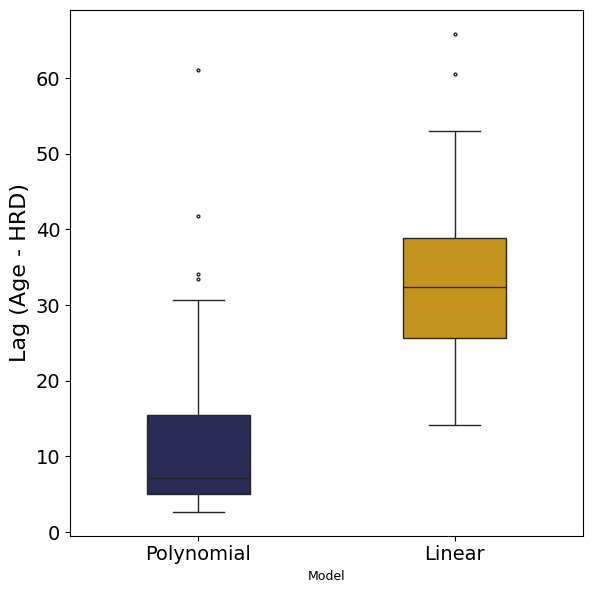

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Define samples to exclude
samples_to_exclude = [
    'PD31145a', 'PD35929a', 'PD36006a', 'PD35926a', 'PD35935a', 'PD36067a', 'PD35990a',
    'PD31129a', 'PD31155a', 'PD35941a', 'PD36024a', 'PD31044a', 'PD31171a', 'PD31178a',
    'PD36054a', 'PD31056a', 
    '7456abd5-303e-4e6f-bf4e-47efefc7310f', 'fc806c50-2f6e-418d-e040-11ac0d485f01',
    '5dbf3203-ce73-41e4-bf9a-32fc856f73f5', '418e916b-7a4e-4fab-8616-15dcec4d79f8',
    'f393bb07-270c-2c93-e040-11ac0d484533', 'b752b444-f033-4be4-9d24-e5e80b4181af',
    '207f8a42-5b05-4876-b0ae-ebfaeea27844', 'd5372745-95cf-4572-a6e7-e7f5b796911a',
    'f393bb0c-4178-ca4a-e040-11ac0d48455f', '987528ac-437a-4eb8-a335-4f2076d5c006',
    'fc8130df-8ec8-5b1e-e040-11ac0d485e06', 'fca6150f-d555-a29e-e040-11ac0d4873b2',
    '43f7a2e0-fec9-4e43-872d-18c6c946fa17', 'Patient33', 'Patient101'
]

df_poly, df_linear = [], []
for name in ["INFORM", "PCAWG", "SCANB"]:
    df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/MC_to_Age_results_{name}.csv")
    df['Cohort'] = name
    df.replace("NA", pd.NA, inplace=True)
    df.dropna(subset=['HRD', 'HRD_low', 'HRD_high'], how='all', inplace=True)
    df.fillna(0, inplace=True)

    # Exclude samples
    df = df[~df['ID'].isin(samples_to_exclude)]

    df_poly.append(df)
    df_linear.append(df.astype({
        'Age': float, 'HRD_linear': float, 
        'HRD_linear_low': float, 'HRD_linear_high': float
    }))

# Concatenate and calculate lag
df_poly = pd.concat(df_poly).sort_values('Age').reset_index(drop=True)
df_linear = pd.concat(df_linear).sort_values('Age').reset_index(drop=True)

df_poly['lag'] = df_poly['Age'] - df_poly['HRD']
df_linear['lag'] = df_linear['Age'] - df_linear['HRD_linear']
df_poly['Model'], df_linear['Model'] = 'Polynomial', 'Linear'

# Combine for plotting
df_all = pd.concat([df_poly[['lag','Model']], df_linear[['lag','Model']]])

# Mann-Whitney U test
stat, p = mannwhitneyu(df_poly['lag'], df_linear['lag'])

# Plot
plt.figure(figsize=(6, 6))
sns.boxplot(
    data=df_all, x='Model', hue='Model', y='lag', 
    palette=["#21255e", "#e0a000"], 
    width=0.4, fliersize=2, linewidth=1,
    legend=False
)
plt.ylabel('Lag (Age - HRD)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/lin_pol_boxplot.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [31]:
df_poly = df_all[df_all['Model'] == 'Polynomial']
df_poly['lag'].median(), df_poly['lag'].mean(), df_poly['lag'].std()

(7.165016501650165, 11.722115262373695, 10.882727233500434)

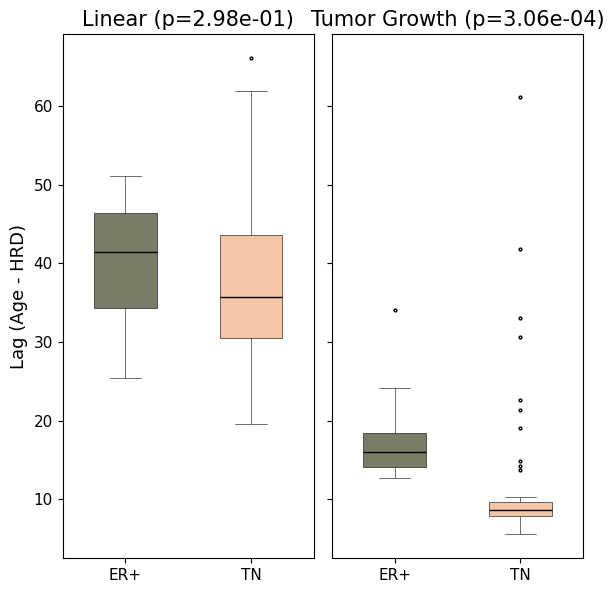

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v5.csv").set_index("sample")

def load_lag_data(model):
    dfs = []
    for name in ["INFORM", "PCAWG", "SCANB"]:
        df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/Jun25_NewAgeModels/MC_to_Age_results_{name}.csv")
        df['Cohort'] = name
        df.replace("NA", pd.NA, inplace=True)
        df.dropna(subset=['HRD_norm_int','HRD_norm_int_low','HRD_norm_int_high'], how='all', inplace=True)
        df.fillna(0, inplace=True)
        dfs.append(df)
    df_all = pd.concat(dfs).sort_values('Age').reset_index(drop=True)
    if model == "Tumor Growth":
        df_all['lag'] = df_all['Age'] - df_all['HRD_norm_int']
    else:
        df_all = df_all.astype({'Age': float, 'HRD_linear': float})
        df_all['lag'] = df_all['Age'] - df_all['HRD_linear']
    df_all['Model'] = model
    return df_all

df_poly = load_lag_data("Tumor Growth")
df_linear = load_lag_data("Linear")

combined = pd.concat([df_poly[['ID', 'lag', 'Model']], df_linear[['ID', 'lag', 'Model']]])
combined = combined.set_index('ID').join(metadata[['type']]).reset_index()
combined = combined[combined['type'].isin(['ER+', 'TN'])]

fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)

# Linear on the left, Tumor Growth Rate on the right
for i, model in enumerate(['Linear', 'Tumor Growth']):
    df_model = combined[combined['Model'] == model]
    er_lag = df_model[df_model['type'] == 'ER+']['lag']
    tn_lag = df_model[df_model['type'] == 'TN']['lag']
    p = mannwhitneyu(er_lag, tn_lag, alternative='two-sided').pvalue
    sns.boxplot(data=df_model, x='type', hue='type', y='lag',
                order=['ER+', 'TN'],  # ensures ER+ is on the left
                palette={'ER+': '#7C7F65', 'TN': '#FFC49B'},
                ax=axes[i], width=0.5, fliersize=2, legend=False,
                boxprops=dict(edgecolor='black', linewidth=0.4),
                whiskerprops=dict(color='black', linewidth=0.4),
                capprops=dict(color='black', linewidth=0.4),
                medianprops=dict(color='black'),
                flierprops=dict(markeredgecolor='black', linewidth=0.5))
    axes[i].set_title(f'{model} (p={p:.2e})', fontsize=15)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Lag (Age - HRD)', fontsize=13)
    axes[i].tick_params(labelsize=11)

plt.tight_layout()
#plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/hrdlag_type.pdf", format='pdf', bbox_inches='tight')
plt.show()


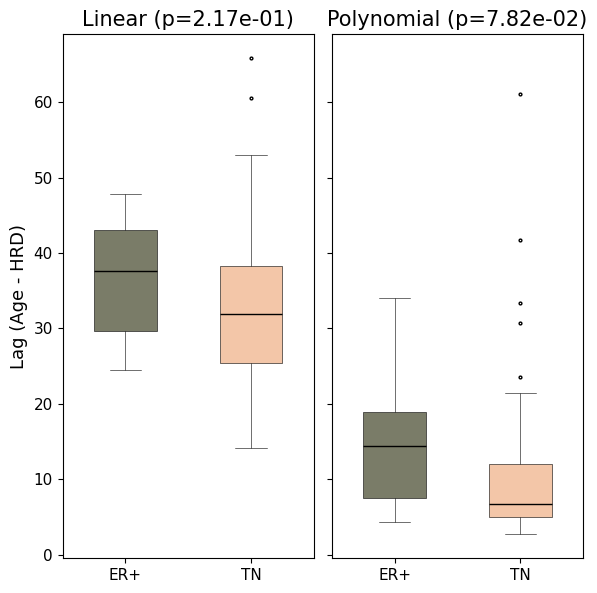

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Load metadata
metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v3.csv").set_index("sample")

# Samples to exclude
samples_to_exclude = [
    'PD31145a', 'PD35929a', 'PD36006a', 'PD35926a', 'PD35935a', 'PD36067a', 'PD35990a',
    'PD31129a', 'PD31155a', 'PD35941a', 'PD36024a', 'PD31044a', 'PD31171a', 'PD31178a',
    'PD36054a', 'PD31056a', 
    '7456abd5-303e-4e6f-bf4e-47efefc7310f', 'fc806c50-2f6e-418d-e040-11ac0d485f01',
    '5dbf3203-ce73-41e4-bf9a-32fc856f73f5', '418e916b-7a4e-4fab-8616-15dcec4d79f8',
    'f393bb07-270c-2c93-e040-11ac0d484533', 'b752b444-f033-4be4-9d24-e5e80b4181af',
    '207f8a42-5b05-4876-b0ae-ebfaeea27844', 'd5372745-95cf-4572-a6e7-e7f5b796911a',
    'f393bb0c-4178-ca4a-e040-11ac0d48455f', '987528ac-437a-4eb8-a335-4f2076d5c006',
    'fc8130df-8ec8-5b1e-e040-11ac0d485e06', 'fca6150f-d555-a29e-e040-11ac0d4873b2',
    '43f7a2e0-fec9-4e43-872d-18c6c946fa17', 'Patient33', 'Patient101'
]

def load_lag_data(model):
    dfs = []
    for name in ["INFORM", "PCAWG", "SCANB"]:
        df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/MC_to_Age_results_{name}.csv")
        df['Cohort'] = name
        df.replace("NA", pd.NA, inplace=True)
        df.dropna(subset=['HRD', 'HRD_low', 'HRD_high'], how='all', inplace=True)
        df.fillna(0, inplace=True)
        
        # Exclude samples
        df = df[~df['ID'].isin(samples_to_exclude)]

        dfs.append(df)
    df_all = pd.concat(dfs).sort_values('Age').reset_index(drop=True)
    if model == "Polynomial":
        df_all['lag'] = df_all['Age'] - df_all['HRD']
    else:
        df_all = df_all.astype({'Age': float, 'HRD_linear': float})
        df_all['lag'] = df_all['Age'] - df_all['HRD_linear']
    df_all['Model'] = model
    return df_all

# Load data with exclusions
df_poly = load_lag_data("Polynomial")
df_linear = load_lag_data("Linear")

# Merge with metadata
combined = pd.concat([df_poly[['ID', 'lag', 'Model']], df_linear[['ID', 'lag', 'Model']]])
combined = combined.set_index('ID').join(metadata[['type']]).reset_index()
combined = combined[combined['type'].isin(['ER+', 'TN'])]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)
for i, model in enumerate(['Linear', 'Polynomial']):
    df_model = combined[combined['Model'] == model]
    er_lag = df_model[df_model['type'] == 'ER+']['lag']
    tn_lag = df_model[df_model['type'] == 'TN']['lag']
    p = mannwhitneyu(er_lag, tn_lag, alternative='two-sided').pvalue
    sns.boxplot(data=df_model, x='type', hue='type', y='lag',
                order=['ER+', 'TN'],
                palette={'ER+': '#7C7F65', 'TN': '#FFC49B'},
                ax=axes[i], width=0.5, fliersize=2, legend=False,
                boxprops=dict(edgecolor='black', linewidth=0.4),
                whiskerprops=dict(color='black', linewidth=0.4),
                capprops=dict(color='black', linewidth=0.4),
                medianprops=dict(color='black'),
                flierprops=dict(markeredgecolor='black', linewidth=0.5))
    axes[i].set_title(f'{model} (p={p:.2e})', fontsize=15)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Lag (Age - HRD)', fontsize=13)
    axes[i].tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/hrdlag_type_final.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
df_poly['ID']

,ID,Age,WGD,WGD_low,WGD_high,HRD,HRD_low,HRD_high,WGD_linear,WGD_linear_low,WGD_linear_high,HRD_linear,HRD_linear_low,HRD_linear_high,Cohort,lag,Model
0,Patient17,27.1,24.571317,24.185104,24.891129,12.715237,0.000000,19.416382,15.790452,14.514221,16.944193,2.414434,0.000000,5.787726,INFORM,14.384763,Polynomial
1,PD31092a,32.0,31.254325,31.123112,31.369537,26.887489,24.464846,28.494049,28.612111,27.889803,29.253730,12.490018,8.222829,16.816223,SCANB,5.112511,Polynomial
2,PD31107a,33.0,30.468647,30.087459,30.887789,29.432343,28.574257,30.163366,19.882282,18.357609,21.716706,16.060669,13.564688,18.650861,SCANB,3.567657,Polynomial
3,f221cbb5-eefa-187f-e040-11ac0c481708,33.0,31.080858,30.765677,31.663366,30.211221,29.359736,31.008251,22.704130,21.233873,25.738645,18.907919,15.889558,22.361736,PCAWG,2.788779,Polynomial
4,PD35962a,36.0,30.046805,29.076508,30.705671,5.326733,0.000000,21.072907,15.013825,13.030186,16.545289,0.800585,0.000000,4.649718,SCANB,30.673267,Polynomial
5,a85cf239-ff51-46e7-9b88-4c2cb49c66b9,36.0,35.198920,34.963096,35.423942,30.428443,27.272727,32.374437,32.363305,31.044817,33.673230,14.247324,8.745505,19.769454,PCAWG,5.571557,Polynomial
6,fc9f6916-da31-ab17-e040-11ac0c4808f3,36.0,30.649865,28.882088,31.546355,16.892889,5.963996,25.218722,10.868916,9.018479,12.372643,4.455566,1.567567,7.054006,PCAWG,19.107111,Polynomial
7,Patient18,36.2,34.943734,34.655916,35.188109,14.772887,0.000000,30.812901,26.619611,24.665919,28.447844,3.787865,0.000000,11.666599,INFORM,21.427113,Polynomial
8,Patient82,37.8,36.669667,36.391809,36.890819,32.157786,25.536454,33.979928,30.751687,28.834137,32.403336,12.275167,6.035999,17.120073,INFORM,5.642214,Polynomial
9,PD36026a,38.0,36.846585,36.702170,36.983398,34.592959,33.243824,35.436644,29.126076,27.921228,30.328007,16.684806,13.164462,20.049614,SCANB,3.407041,Polynomial


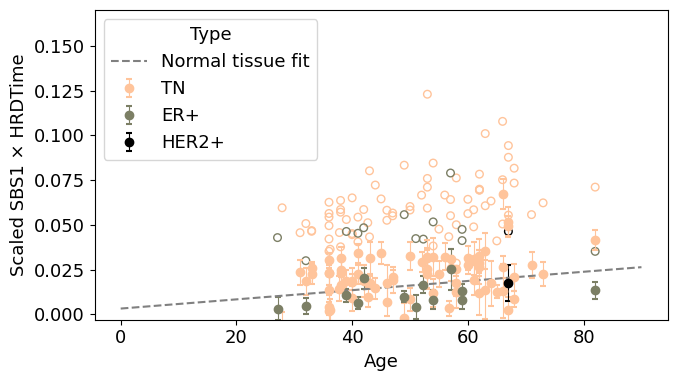

In [ ]:
# Load and filter data
metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v3.csv").set_index("sample")
BulkTumor = BulkTumor[BulkTumor['aliquot_id'].isin(df_poly['ID'])]

# Cohort-specific HRD timing data
cohorts = {"PCAWG": PCAWG_HRDTimer, "SCANB": SCANB_HRDTimer, "INFORM": INFORM_HRDTimer}
colors = {'ER+': '#7C7F65', 'TN': '#FFC49B', 'HER2+': 'black'}

# Merge cohort data with metadata
merged_data = [pd.merge(BulkTumor[BulkTumor['Cohort'] == cohort], hrd, left_on='aliquot_id', right_on='ID')
               .drop(columns='ID').set_index('aliquot_id').join(metadata[['type']])
               for cohort, hrd in cohorts.items()]
full_data = pd.concat(merged_data)

# x = age, y = scaled_SBS1 * HRDTime, yerr = scaled_SBS1 * HRDTime_ci
x, y, yerr, type_values = full_data['age'], full_data['scaled_SBS1'] * full_data['HRDTime'], \
                          full_data['scaled_SBS1'] * full_data['HRDTime_ci'], full_data['type']

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
for t in ['TN', 'ER+', 'HER2+']:
    subset = full_data[type_values == t]
    plt.errorbar(subset['age'], subset['scaled_SBS1'] * subset['HRDTime'], 
                 yerr=subset['scaled_SBS1'] * subset['HRDTime_ci'], fmt='o', 
                 color=colors[t], label=t, alpha=1, elinewidth=0.8, capsize=2, capthick=1.5)
    plt.scatter(subset['age'], subset['scaled_SBS1'], color=colors[t], 
                edgecolor=colors[t], facecolors='none', s=30, alpha=1)

# Normal tissue regression
x_norm, y_norm = NormalTissue['age'], NormalTissue['scaled_SBS1']
slope_norm, intercept_norm, *_ = linregress(x_norm, y_norm)
plt.plot(np.linspace(0, 90, 1000), slope_norm * np.linspace(0, 90, 1000) + intercept_norm, 
         label='Normal tissue fit', color='gray', linestyle='--')
plt.xlabel("Age")
plt.ylabel("Scaled SBS1 × HRDTime")
plt.legend(title="Type")
plt.tight_layout()
plt.ylim(-0.003, 0.17)
#plt.savefig("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/hrd_ScaledSBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()


Number of data points plotted: 59


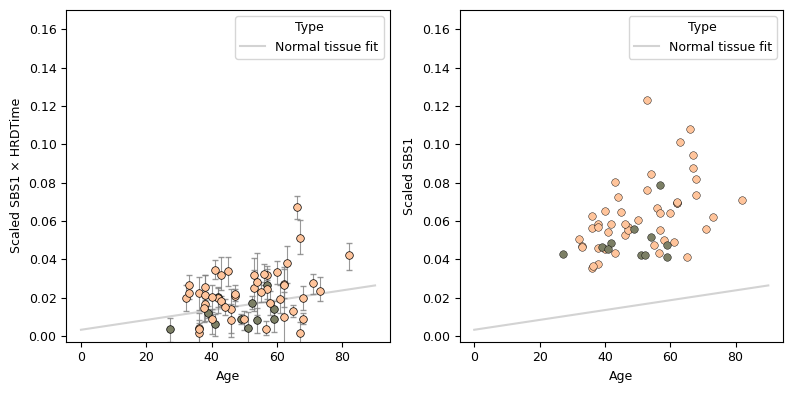

In [50]:
# Load and filter data
metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v3.csv").set_index("sample")
BulkTumor = BulkTumor[BulkTumor['aliquot_id'].isin(df_poly['ID'])]
#BulkTumor = BulkTumor[BulkTumor['aliquot_id'].isin(sample_order)]

# Samples to exclude
samples_to_exclude = [
    'PD31145a', 'PD35929a', 'PD36006a', 'PD35926a', 'PD35935a', 'PD36067a', 'PD35990a',
    'PD31129a', 'PD31155a', 'PD35941a', 'PD36024a', 'PD31044a', 'PD31171a', 'PD31178a',
    'PD36054a', 'PD31056a', 
    '7456abd5-303e-4e6f-bf4e-47efefc7310f', 'fc806c50-2f6e-418d-e040-11ac0d485f01',
    '5dbf3203-ce73-41e4-bf9a-32fc856f73f5', '418e916b-7a4e-4fab-8616-15dcec4d79f8',
    'f393bb07-270c-2c93-e040-11ac0d484533', 'b752b444-f033-4be4-9d24-e5e80b4181af',
    '207f8a42-5b05-4876-b0ae-ebfaeea27844', 'd5372745-95cf-4572-a6e7-e7f5b796911a',
    'f393bb0c-4178-ca4a-e040-11ac0d48455f', '987528ac-437a-4eb8-a335-4f2076d5c006',
    'fc8130df-8ec8-5b1e-e040-11ac0d485e06', 'fca6150f-d555-a29e-e040-11ac0d4873b2',
    '43f7a2e0-fec9-4e43-872d-18c6c946fa17', 'Patient33', 'Patient101'
]

# Cohort-specific HRD timing data
cohorts = {"PCAWG": PCAWG_HRDTimer, "SCANB": SCANB_HRDTimer, "INFORM": INFORM_HRDTimer}
colors = {'ER+': '#7C7F65', 'TN': '#FFC49B', 'HER2+': 'black'}

# Merge cohort data with metadata
merged_data = [pd.merge(BulkTumor[BulkTumor['Cohort'] == cohort], hrd, left_on='aliquot_id', right_on='ID')
               .drop(columns='ID').set_index('aliquot_id').join(metadata[['type']])
               for cohort, hrd in cohorts.items()]
full_data = pd.concat(merged_data)

# Exclude unwanted samples
full_data = full_data[~full_data.index.isin(samples_to_exclude)]
print(f"Number of data points plotted: {len(full_data)}")


# x = age, y = scaled_SBS1 * HRDTime, yerr = scaled_SBS1 * HRDTime_ci
x, y, yerr_hi, yerr_lo, type_values = full_data['age'], full_data['scaled_SBS1'] * full_data['HRDTime'], \
                             full_data['scaled_SBS1'] * full_data['HRDTime_ci_hi'],  \
                             full_data['scaled_SBS1'] * full_data['HRDTime_ci_lo'], \
                             full_data['type']

# Set up side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

# Plot 1: scaled_SBS1 * HRDTime with error bars and black-bordered markers
for t in ['HER2+', 'ER+', 'TN']:
    subset = full_data[type_values == t]
    # Plot error bars only
    ax1.errorbar(subset['age'], subset['scaled_SBS1'] * subset['HRDTime'], 
             yerr=[
                 subset['scaled_SBS1'] * subset['HRDTime_ci_lo'], 
                 subset['scaled_SBS1'] * subset['HRDTime_ci_hi']
             ],
             fmt='none', ecolor='grey', alpha=0.8, elinewidth=0.8,
             capsize=2, capthick=1.0, zorder=1)

    # Plot markers with black border
    ax1.scatter(subset['age'], subset['scaled_SBS1'] * subset['HRDTime'],
                facecolor=colors[t], edgecolor='black', s=30, alpha=1, linewidth=0.5, zorder=2)

# Regression line from normal tissue
x_norm, y_norm = NormalTissue['age'], NormalTissue['scaled_SBS1']
slope_norm, intercept_norm, *_ = linregress(x_norm, y_norm)
x_fit = np.linspace(0, 90, 1000)
y_fit = slope_norm * x_fit + intercept_norm
ax1.plot(x_fit, y_fit, '-', color='lightgray', label='Normal tissue fit', zorder=0)
ax1.set_xlabel("Age")
ax1.set_ylabel("Scaled SBS1 × HRDTime")
ax1.legend(title="Type")
ax1.set_ylim(-0.003, 0.17)

# Plot 2: raw scaled_SBS1 values (also with black border)
for t in ['TN', 'ER+', 'HER2+']:
    subset = full_data[type_values == t]
    ax2.scatter(subset['age'], subset['scaled_SBS1'],
                facecolor=colors[t], edgecolor='black', s=30, alpha=1, linewidth=0.3)

# Regression line for normal tissue
ax2.plot(x_fit, y_fit, '-', color='lightgray', label='Normal tissue fit')
ax2.set_xlabel("Age")
ax2.set_ylabel("Scaled SBS1")
ax2.legend(title="Type")
ax2.set_ylim(-0.003, 0.17)

plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/hrd_ScaledSBS1_final.pdf", format='pdf', bbox_inches='tight')
plt.show()

